In [1]:
pip install pandas scikit-learn tensorflow matplotlib seaborn statsmodels

In [10]:
# importing all the necessory libraries in this block

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
import calendar

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from scipy import stats
#from scipy.stats import pearsonr

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
#from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.losses import Huber





Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Loading and Initial Exploration

In [3]:
# Load the HomeC dataset as raw_data
raw_data = pd.read_csv('/content/drive/MyDrive/Google colab/HomeC.csv')

<ipython-input-3-c5f7f763477d>:2: DtypeWarning: Columns (0,27) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv('/content/drive/MyDrive/Google colab/HomeC.csv')


In [4]:
# This command is used to display all columns in dataset
pd.set_option('display.max_columns', None)

# Display the first and last five rows of the dataset
print("Data Sample (First 5 Rows):")
print(raw_data.head())
print("\nData Sample (Last 5 Rows):")
print(raw_data.tail())

Data Sample (First 5 Rows):
         time  use [kW]  gen [kW]  House overall [kW]  Dishwasher [kW]  \
0  1451624400  0.932833  0.003483            0.932833         0.000033   
1  1451624401  0.934333  0.003467            0.934333         0.000000   
2  1451624402  0.931817  0.003467            0.931817         0.000017   
3  1451624403  1.022050  0.003483            1.022050         0.000017   
4  1451624404  1.139400  0.003467            1.139400         0.000133   

   Furnace 1 [kW]  Furnace 2 [kW]  Home office [kW]  Fridge [kW]  \
0        0.020700        0.061917          0.442633     0.124150   
1        0.020717        0.063817          0.444067     0.124000   
2        0.020700        0.062317          0.446067     0.123533   
3        0.106900        0.068517          0.446583     0.123133   
4        0.236933        0.063983          0.446533     0.122850   

   Wine cellar [kW]  Garage door [kW]  Kitchen 12 [kW]  Kitchen 14 [kW]  \
0          0.006983          0.013083      

## Data Cleaning and Pre-processing

In [5]:
# Removing the last row as it is invalid
raw_data = raw_data[0:-1]

In [6]:
# Remove '[kW]' from column to access the columns easily
raw_data.columns = [col.replace(' [kW]', '') for col in raw_data.columns]

In [7]:
# Combine Furnace1 and Furnace2 as 'Furnace' and Kitchen 12, Kitchen 14 as 'Kitchen'
raw_data['Furnace'] = raw_data['Furnace 1'] + raw_data['Furnace 2']
raw_data['Kitchen'] = raw_data[['Kitchen 12', 'Kitchen 14']].sum(axis=1)

In [8]:
# Removing unnecessary columns from the dataset
columns_to_remove = ['Furnace 1', 'Furnace 2', 'Kitchen 12', 'Kitchen 14', 'House overall','Solar', 'summary', 'Kitchen 38', 'cloudCover']
raw_data = raw_data.drop(columns=columns_to_remove)

In [11]:
# Converting the Unix time format to the normal format
print('Unix conversion performed.\nStarting Time: ' , time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(int(raw_data['time'].iloc[0]))))

Unix conversion performed.
Starting Time:  2016-01-01 05:00:00


In [12]:
# Generate the datetime series
datetime = pd.date_range('2016-01-01 05:00', periods=len(raw_data), freq='min')

# Add the datetime series as a new column in the DataFrame
raw_data['datetime'] = datetime

# Drop the old 'time' column from the DataFrame
raw_data = raw_data.drop(['time'], axis=1)
raw_data.head()

,use,gen,Dishwasher,Home office,Fridge,Wine cellar,Garage door,Barn,Well,Microwave,Living room,temperature,icon,humidity,visibility,apparentTemperature,pressure,windSpeed,windBearing,precipIntensity,dewPoint,precipProbability,Furnace,Kitchen,datetime
0,0.932833,0.003483,0.000033,0.442633,0.124150,0.006983,0.013083,0.031350,0.001017,0.004067,0.001517,36.14,clear-night,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0,0.082617,0.000567,2016-01-01 05:00:00
1,0.934333,0.003467,0.000000,0.444067,0.124000,0.006983,0.013117,0.031500,0.001017,0.004067,0.001650,36.14,clear-night,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0,0.084533,0.000567,2016-01-01 05:01:00
2,0.931817,0.003467,0.000017,0.446067,0.123533,0.006983,0.013083,0.031517,0.001000,0.004067,0.001650,36.14,clear-night,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0,0.083017,0.000600,2016-01-01 05:02:00
3,1.022050,0.003483,0.000017,0.446583,0.123133,0.006983,0.013000,0.031500,0.001017,0.004067,0.001617,36.14,clear-night,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0,0.175417,0.000650,2016-01-01 05:03:00
4,1.139400,0.003467,0.000133,0.446533,0.122850,0.006850,0.012783,0.031500,0.001017,0.004067,0.001583,36.14,clear-night,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0,0.300917,0.000783,2016-01-01 05:04:00


In [13]:
raw_data['datetime'] = pd.to_datetime(raw_data['datetime'], unit='s')

# Extracting the required components from the date time column
raw_data['date'] = raw_data['datetime'].dt.date
raw_data['hour'] = raw_data['datetime'].dt.hour
raw_data['minute'] = raw_data['datetime'].dt.minute
raw_data['week'] = raw_data['datetime'].dt.isocalendar().week
raw_data['month'] = raw_data['datetime'].dt.month

In [14]:
# Round all numeric columns to 4 decimal places
numeric_cols = raw_data.select_dtypes(include=['float64']).columns
raw_data[numeric_cols] = raw_data[numeric_cols].round(4)

In [15]:
raw_data.head()

,use,gen,Dishwasher,Home office,Fridge,Wine cellar,Garage door,Barn,Well,Microwave,Living room,temperature,icon,humidity,visibility,apparentTemperature,pressure,windSpeed,windBearing,precipIntensity,dewPoint,precipProbability,Furnace,Kitchen,datetime,date,hour,minute,week,month
0,0.9328,0.0035,0.0000,0.4426,0.1242,0.0070,0.0131,0.0314,0.001,0.0041,0.0015,36.14,clear-night,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0,0.0826,0.0006,2016-01-01 05:00:00,2016-01-01,5,0,53,1
1,0.9343,0.0035,0.0000,0.4441,0.1240,0.0070,0.0131,0.0315,0.001,0.0041,0.0016,36.14,clear-night,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0,0.0845,0.0006,2016-01-01 05:01:00,2016-01-01,5,1,53,1
2,0.9318,0.0035,0.0000,0.4461,0.1235,0.0070,0.0131,0.0315,0.001,0.0041,0.0016,36.14,clear-night,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0,0.0830,0.0006,2016-01-01 05:02:00,2016-01-01,5,2,53,1
3,1.0220,0.0035,0.0000,0.4466,0.1231,0.0070,0.0130,0.0315,0.001,0.0041,0.0016,36.14,clear-night,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0,0.1754,0.0006,2016-01-01 05:03:00,2016-01-01,5,3,53,1
4,1.1394,0.0035,0.0001,0.4465,0.1228,0.0068,0.0128,0.0315,0.001,0.0041,0.0016,36.14,clear-night,0.62,10.0,29.26,1016.91,9.18,282.0,0.0,24.4,0.0,0.3009,0.0008,2016-01-01 05:04:00,2016-01-01,5,4,53,1


In [16]:
# Display the columns after removing
print("\nColumns after removing:")
print(raw_data.columns)


Columns after removing:
Index(['use', 'gen', 'Dishwasher', 'Home office', 'Fridge', 'Wine cellar',
       'Garage door', 'Barn', 'Well', 'Microwave', 'Living room',
       'temperature', 'icon', 'humidity', 'visibility', 'apparentTemperature',
       'pressure', 'windSpeed', 'windBearing', 'precipIntensity', 'dewPoint',
       'precipProbability', 'Furnace', 'Kitchen', 'datetime', 'date', 'hour',
       'minute', 'week', 'month'],
      dtype='object')


In [17]:
# Define a function to categorize time of day using the hours column
def categorize_time_of_day(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 22:
        return 'Evening'
    else:
        return 'Night'

# Apply the function to the hour column to create a new column 'time_of_day'
raw_data['time_of_day'] = raw_data['hour'].apply(categorize_time_of_day)

In [18]:
# Define a function to categorize seasons using month column
def categorize_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

# Apply the function to the 'month' column to create a new column season
raw_data['season'] = raw_data['month'].apply(categorize_season)

In [19]:
# Save the cleaned data to a new file
raw_data.to_csv('/content/drive/MyDrive/Google colab/clean_data.csv', index=False)

In [20]:
# Load the cleaned dataset
data = pd.read_csv('/content/drive/MyDrive/Google colab/clean_data.csv')

In [21]:
# View shape of data
data.shape

(503910, 32)

In [22]:
# Display basic information about the dataset
print("Basic Information:")
data.info()

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503910 entries, 0 to 503909
Data columns (total 32 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   use                  503910 non-null  float64
 1   gen                  503910 non-null  float64
 2   Dishwasher           503910 non-null  float64
 3   Home office          503910 non-null  float64
 4   Fridge               503910 non-null  float64
 5   Wine cellar          503910 non-null  float64
 6   Garage door          503910 non-null  float64
 7   Barn                 503910 non-null  float64
 8   Well                 503910 non-null  float64
 9   Microwave            503910 non-null  float64
 10  Living room          503910 non-null  float64
 11  temperature          503910 non-null  float64
 12  icon                 503910 non-null  object 
 13  humidity             503910 non-null  float64
 14  visibility           503910 non-null  float64
 15

In [23]:
# Display the head and tail of the dataset
print("First 5 Rows:")
print(data.head())
print("Last 5 Rows:")
print(data.tail())

First 5 Rows:
      use     gen  Dishwasher  Home office  Fridge  Wine cellar  Garage door  \
0  0.9328  0.0035      0.0000       0.4426  0.1242       0.0070       0.0131   
1  0.9343  0.0035      0.0000       0.4441  0.1240       0.0070       0.0131   
2  0.9318  0.0035      0.0000       0.4461  0.1235       0.0070       0.0131   
3  1.0220  0.0035      0.0000       0.4466  0.1231       0.0070       0.0130   
4  1.1394  0.0035      0.0001       0.4465  0.1228       0.0068       0.0128   

     Barn   Well  Microwave  Living room  temperature         icon  humidity  \
0  0.0314  0.001     0.0041       0.0015        36.14  clear-night      0.62   
1  0.0315  0.001     0.0041       0.0016        36.14  clear-night      0.62   
2  0.0315  0.001     0.0041       0.0016        36.14  clear-night      0.62   
3  0.0315  0.001     0.0041       0.0016        36.14  clear-night      0.62   
4  0.0315  0.001     0.0041       0.0016        36.14  clear-night      0.62   

   visibility  apparentT

In [24]:
data.columns

Index(['use', 'gen', 'Dishwasher', 'Home office', 'Fridge', 'Wine cellar',
       'Garage door', 'Barn', 'Well', 'Microwave', 'Living room',
       'temperature', 'icon', 'humidity', 'visibility', 'apparentTemperature',
       'pressure', 'windSpeed', 'windBearing', 'precipIntensity', 'dewPoint',
       'precipProbability', 'Furnace', 'Kitchen', 'datetime', 'date', 'hour',
       'minute', 'week', 'month', 'time_of_day', 'season'],
      dtype='object')

In [25]:
# Check for unique values in the icon, time_of_day, season column
print("\nUnique values in 'icon' column:")
print(data['icon'].unique())
print("\nUnique values in 'time_of_day' column:")
print(data['time_of_day'].unique())
print("\nUnique values in 'season' column:")
print(data['season'].unique())


Unique values in 'icon' column:
['clear-night' 'partly-cloudy-night' 'clear-day' 'cloudy'
 'partly-cloudy-day' 'rain' 'snow' 'wind' 'fog']

Unique values in 'time_of_day' column:
['Night' 'Morning' 'Afternoon' 'Evening']

Unique values in 'season' column:
['Winter' 'Spring' 'Summer' 'Fall']


In [26]:
# Check for duplicate rows
duplicates = data.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


In [27]:
# Check for missing values
print("Missing Values:")
print(data.isnull().sum())

Missing Values:
use                    0
gen                    0
Dishwasher             0
Home office            0
Fridge                 0
Wine cellar            0
Garage door            0
Barn                   0
Well                   0
Microwave              0
Living room            0
temperature            0
icon                   0
humidity               0
visibility             0
apparentTemperature    0
pressure               0
windSpeed              0
windBearing            0
precipIntensity        0
dewPoint               0
precipProbability      0
Furnace                0
Kitchen                0
datetime               0
date                   0
hour                   0
minute                 0
week                   0
month                  0
time_of_day            0
season                 0
dtype: int64


In [28]:
# Display summary statistics of the dataset
print("Summary Statistics:")
print(data.describe())

Summary Statistics:
                 use            gen     Dishwasher    Home office  \
count  503910.000000  503910.000000  503910.000000  503910.000000   
mean        0.858962       0.076230       0.031362       0.081287   
std         1.058207       0.128427       0.190952       0.104466   
min         0.000000       0.000000       0.000000       0.000100   
25%         0.367700       0.003400       0.000000       0.040400   
50%         0.562300       0.004300       0.000000       0.042200   
75%         0.970200       0.083900       0.000200       0.068300   
max        14.714600       0.613900       1.401800       0.971800   

              Fridge    Wine cellar    Garage door           Barn  \
count  503910.000000  503910.000000  503910.000000  503910.000000   
mean        0.063557       0.042136       0.014138       0.058530   
std         0.076198       0.057967       0.014292       0.202706   
min         0.000100       0.000000       0.000000       0.000000   
25%         0

## Exploratory Data Analysis (EDA)

In [29]:
# Convert datetime column to datetime type
data['datetime'] = pd.to_datetime(data['date'])

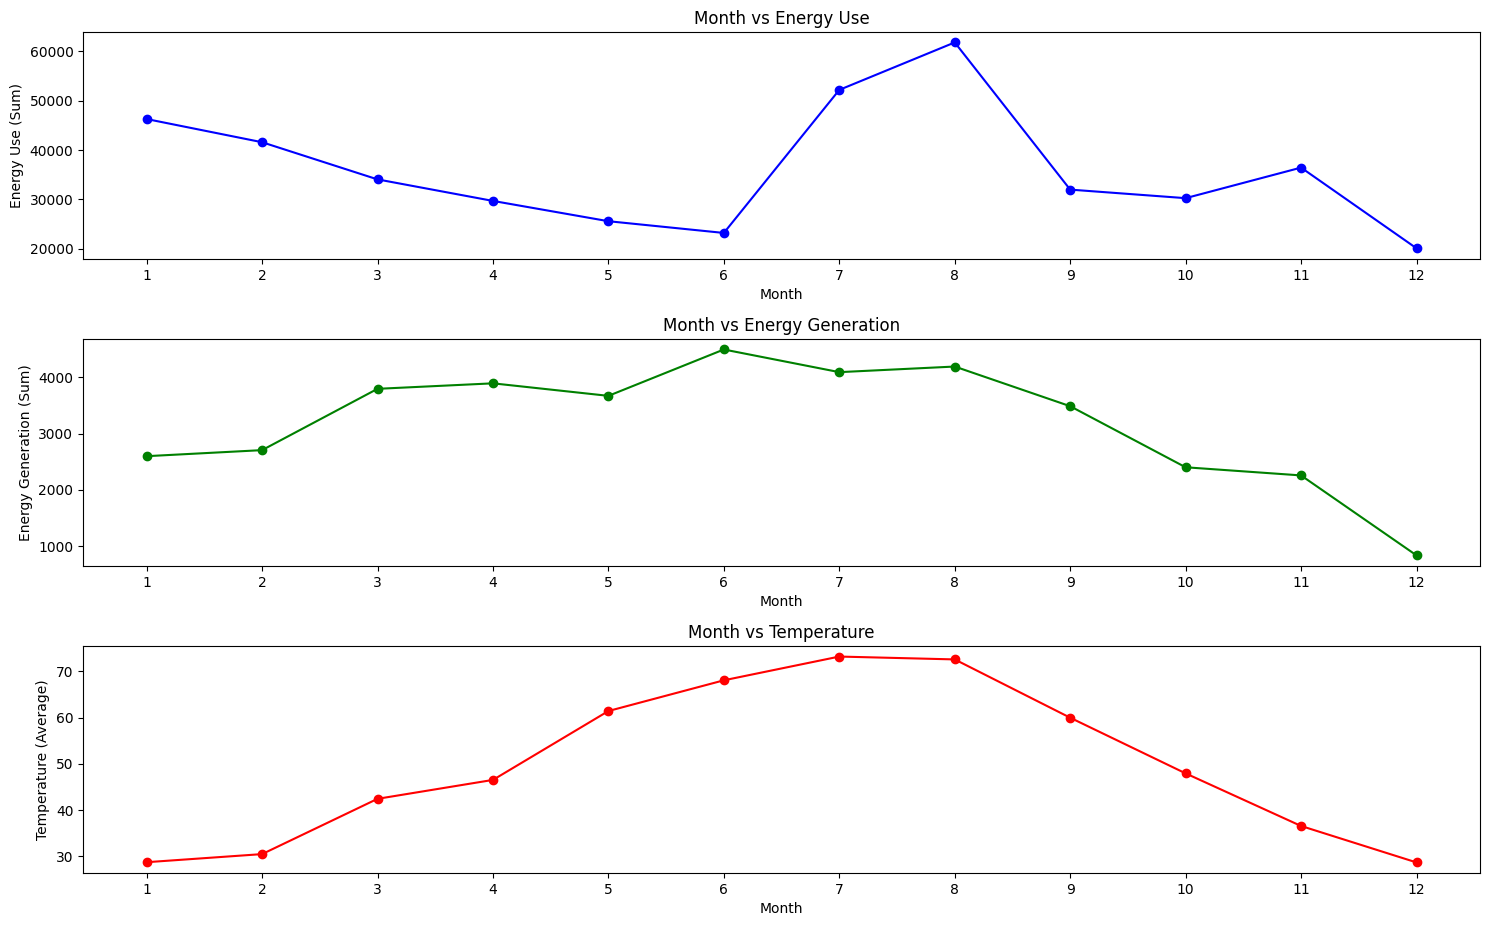

In [30]:
# Grouping the data by month and summing/averaging the required columns
monthly_energy_use = data.groupby('month')['use'].sum()
monthly_energy_gen = data.groupby('month')['gen'].sum()
monthly_temperature = data.groupby('month')['temperature'].mean()

plt.figure(figsize=(15, 12))

# 1. Month vs Energy Use
plt.subplot(4, 1, 1)
plt.plot(monthly_energy_use.index, monthly_energy_use.values, marker='o', color='b')
plt.title('Month vs Energy Use')
plt.xlabel('Month')
plt.ylabel('Energy Use (Sum)')
plt.xticks(range(1, 13))

# 2. Month vs Energy Generation
plt.subplot(4, 1, 2)
plt.plot(monthly_energy_gen.index, monthly_energy_gen.values, marker='o', color='g')
plt.title('Month vs Energy Generation')
plt.xlabel('Month')
plt.ylabel('Energy Generation (Sum)')
plt.xticks(range(1, 13))

# 3. Month vs Temperature
plt.subplot(4, 1, 3)
plt.plot(monthly_temperature.index, monthly_temperature.values, marker='o', color='r')
plt.title('Month vs Temperature')
plt.xlabel('Month')
plt.ylabel('Temperature (Average)')
plt.xticks(range(1, 13))

plt.tight_layout()
plt.show()


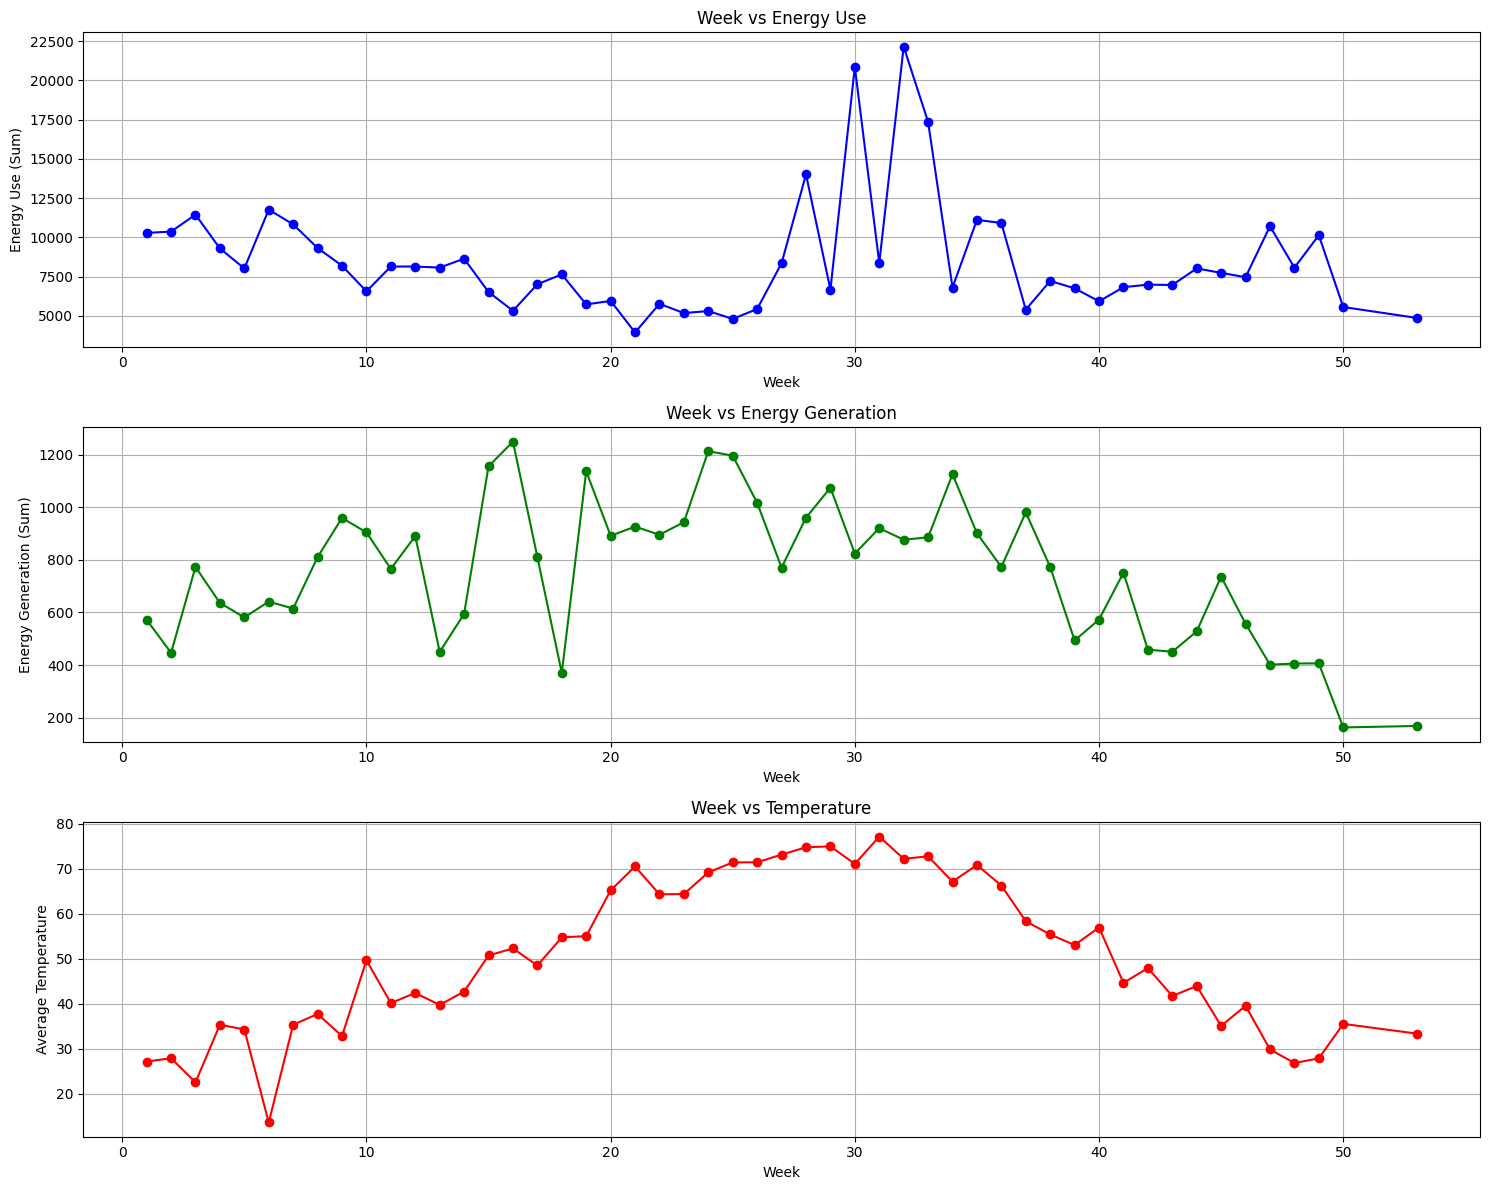

In [31]:
cleaned_data = data

cleaned_data['date'] = pd.to_datetime(cleaned_data['date'])

# Extract week information from the 'date' column
cleaned_data['week'] = cleaned_data['date'].dt.isocalendar().week

# Group by week and sum the use, gen, and average the temperature for each week
weekly_use = cleaned_data.groupby('week')['use'].sum()
weekly_gen = cleaned_data.groupby('week')['gen'].sum()
weekly_temperature = cleaned_data.groupby('week')['temperature'].mean()

plt.figure(figsize=(15, 12))

# 1. Week vs Energy Use
plt.subplot(3, 1, 1)
plt.plot(weekly_use.index, weekly_use.values, marker='o', color='b')
plt.title('Week vs Energy Use')
plt.xlabel('Week')
plt.ylabel('Energy Use (Sum)')
plt.grid(True)

# 2. Week vs Energy Generation
plt.subplot(3, 1, 2)
plt.plot(weekly_gen.index, weekly_gen.values, marker='o', color='g')
plt.title('Week vs Energy Generation')
plt.xlabel('Week')
plt.ylabel('Energy Generation (Sum)')
plt.grid(True)

# 3. Week vs Temperature
plt.subplot(3, 1, 3)
plt.plot(weekly_temperature.index, weekly_temperature.values, marker='o', color='r')
plt.title('Week vs Temperature')
plt.xlabel('Week')
plt.ylabel('Average Temperature')
plt.grid(True)

plt.tight_layout()
plt.show()

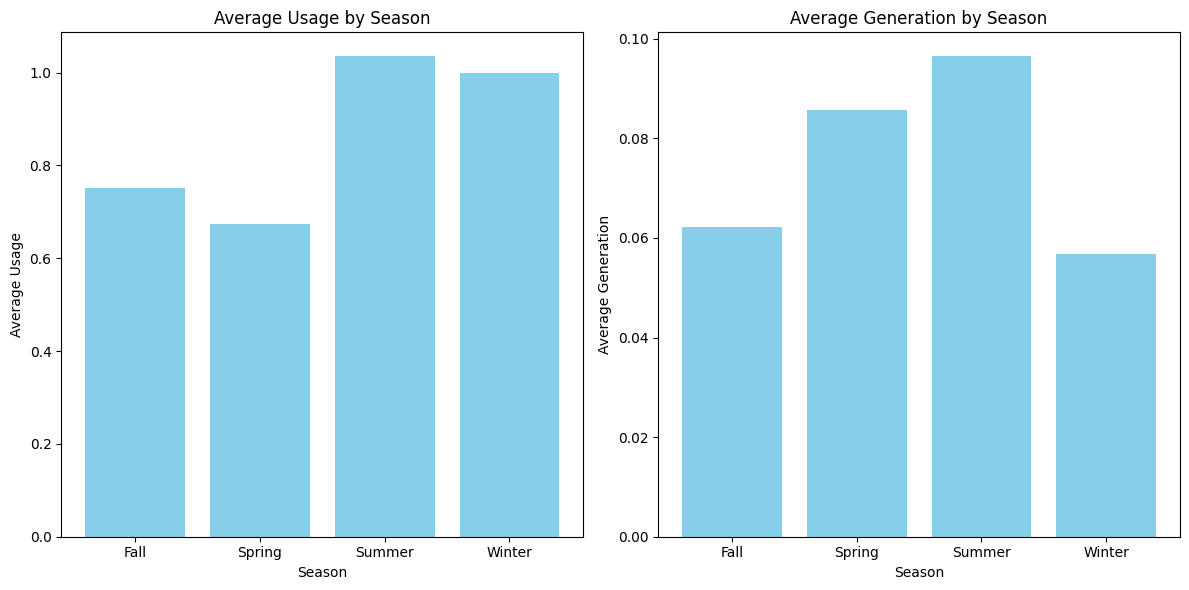

In [32]:
# Group by 'season' and calculate the mean of 'use' and 'gen'
seasonal_data = data.groupby('season')[['use', 'gen']].mean().reset_index()

# Create a figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1: Season vs Use
ax1.bar(seasonal_data['season'], seasonal_data['use'], color='skyblue')
ax1.set_xlabel('Season')
ax1.set_ylabel('Average Usage')
ax1.set_title('Average Usage by Season')

# Plot 2: Season vs Generation
ax2.bar(seasonal_data['season'], seasonal_data['gen'], color='skyblue')
ax2.set_xlabel('Season')
ax2.set_ylabel('Average Generation')
ax2.set_title('Average Generation by Season')

plt.tight_layout()
plt.show()

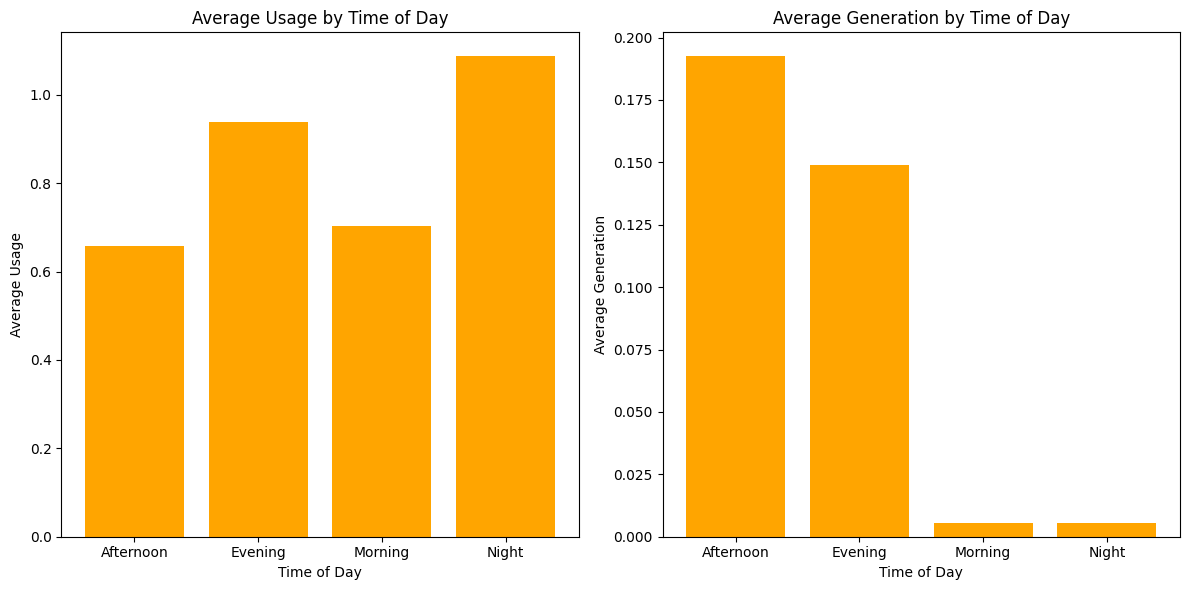

In [33]:
# Group by time of the day and calculate the mean of 'use' and 'gen'
time_of_day_data = data.groupby('time_of_day')[['use','gen']].mean().reset_index()
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 6))

# Plot 3: Time of Day vs Use
ax3.bar(time_of_day_data['time_of_day'], time_of_day_data['use'], color='orange')
ax3.set_xlabel('Time of Day')
ax3.set_ylabel('Average Usage')
ax3.set_title('Average Usage by Time of Day')

# Plot 4: Time of Day vs Generation
ax4.bar(time_of_day_data['time_of_day'], time_of_day_data['gen'], color='orange')
ax4.set_xlabel('Time of Day')
ax4.set_ylabel('Average Generation')
ax4.set_title('Average Generation by Time of Day')

plt.tight_layout()
plt.show()

In [34]:
# divide appliance and weather related columns
appliance_columns = ['Dishwasher', 'Furnace', 'Home office',
                     'Fridge', 'Wine cellar', 'Garage door', 'Barn',
                     'Well', 'Microwave', 'Living room', 'Kitchen']

weather_columns = ['temperature', 'humidity', 'visibility', 'apparentTemperature',
                   'pressure', 'windSpeed', 'windBearing', 'precipIntensity',
                   'dewPoint', 'precipProbability']

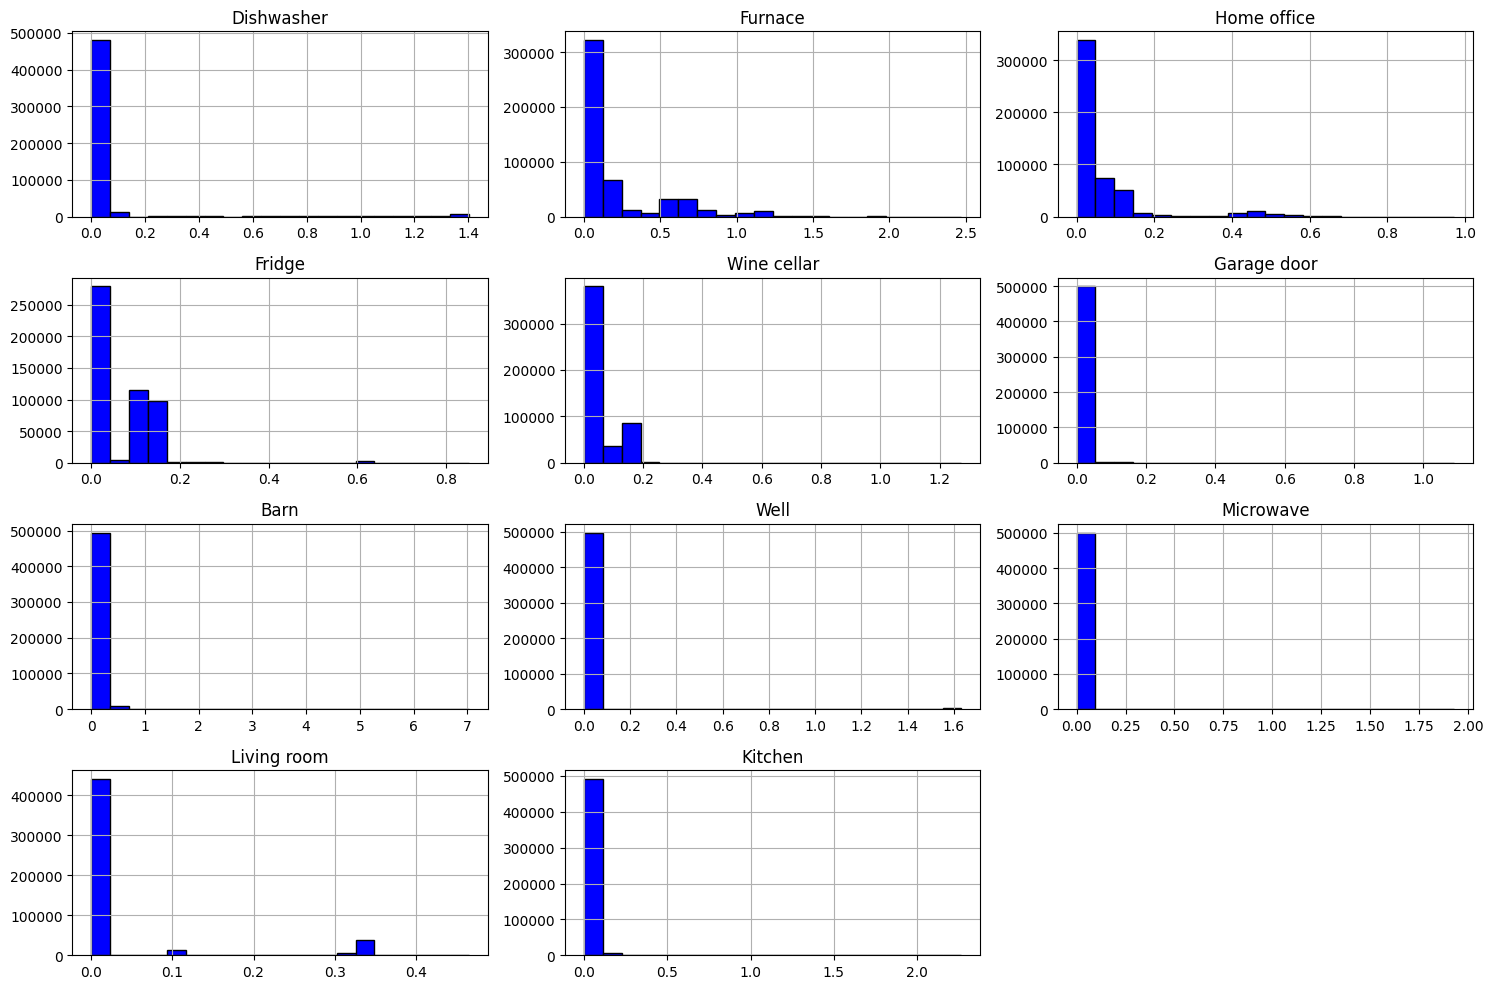

In [35]:
# Plot histograms for appliance columns
data[appliance_columns].hist(figsize=(15, 10), bins=20, color='blue', edgecolor='black')
plt.tight_layout()
plt.show()


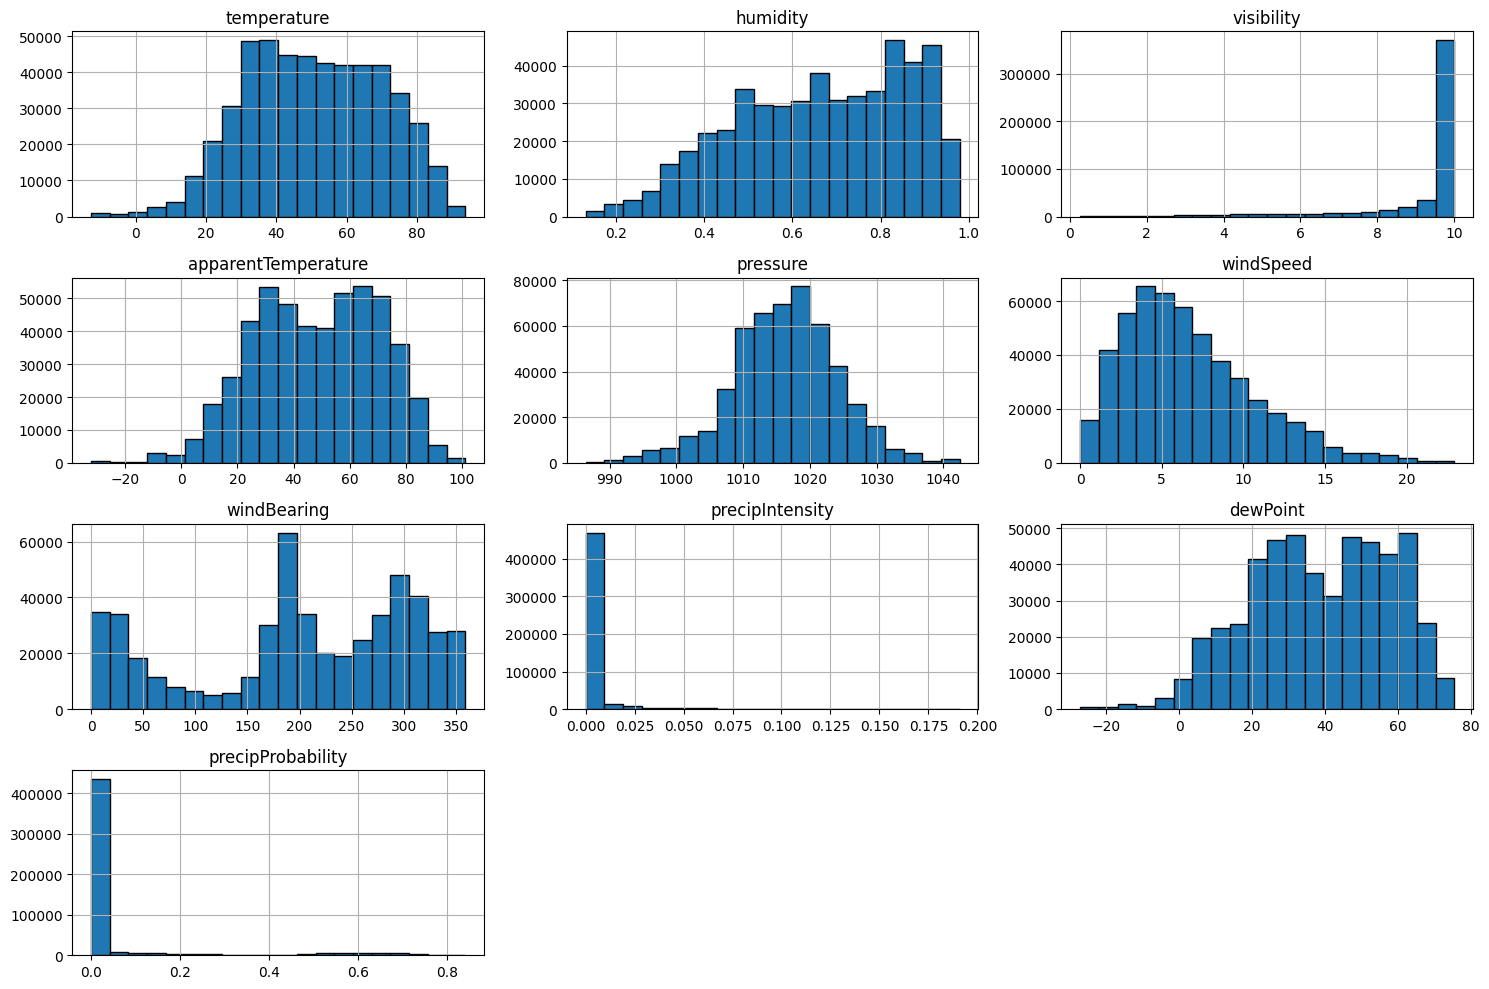

In [36]:
# Plot histograms for weather-related columns
data[weather_columns].hist(figsize=(15, 10), bins=20, edgecolor='black')
plt.tight_layout()
plt.show()

<ipython-input-37-8fe1c590cf60>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=total_consumption, x='Appliance', y='Total Consumption', ax=ax2, palette=colors)


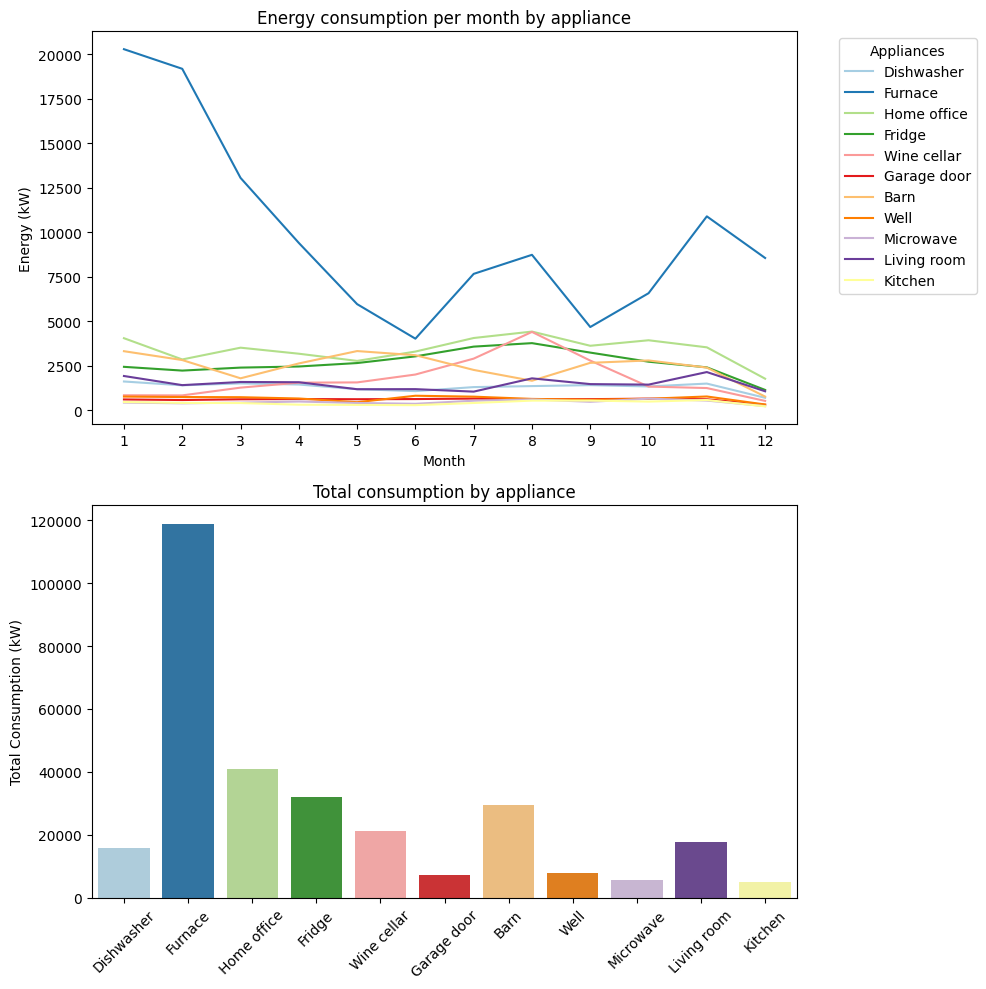

In [37]:
monthly_use = data.groupby('month')[appliance_columns].sum().reset_index()

# Sort by month to ensure order from January (1) to December (12)
monthly_use = monthly_use.sort_values('month')

# Filter out negative values from the dataset
monthly_use[appliance_columns] = monthly_use[appliance_columns].clip(lower=0)

# Sum the total energy consumption for each appliance for the bar plot
total_consumption = data[appliance_columns].sum().reset_index()
total_consumption.columns = ['Appliance', 'Total Consumption']

# Filter out negative values from total consumption
total_consumption['Total Consumption'] = total_consumption['Total Consumption'].clip(lower=0)

# Define a color palette
colors = sns.color_palette('Paired', len(appliance_columns))

# Create the subplots of 1x2 grid
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Line plot for monthly consumption by appliance with consistent colors
for appliance, color in zip(appliance_columns, colors):
    ax1.plot(monthly_use['month'], monthly_use[appliance], label=appliance, color=color)

ax1.set_title('Energy consumption per month by appliance')
ax1.set_ylabel('Energy (kW)')
ax1.set_xlabel('Month')
ax1.set_xticks(range(1, 13))
ax1.legend(title='Appliances', bbox_to_anchor=(1.05, 1), loc='upper left')

# Bar plot for total consumption by appliance with the same colors
sns.barplot(data=total_consumption, x='Appliance', y='Total Consumption', ax=ax2, palette=colors)
ax2.set_title('Total consumption by appliance')
ax2.set_ylabel('Total Consumption (kW)')
ax2.set_xlabel('')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

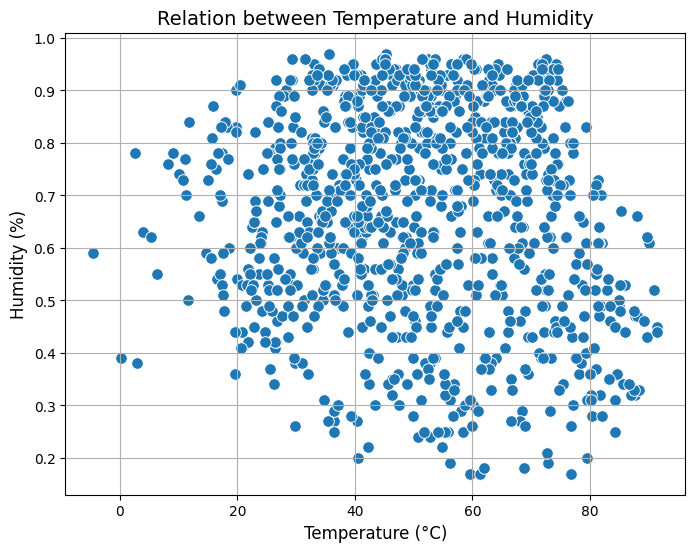

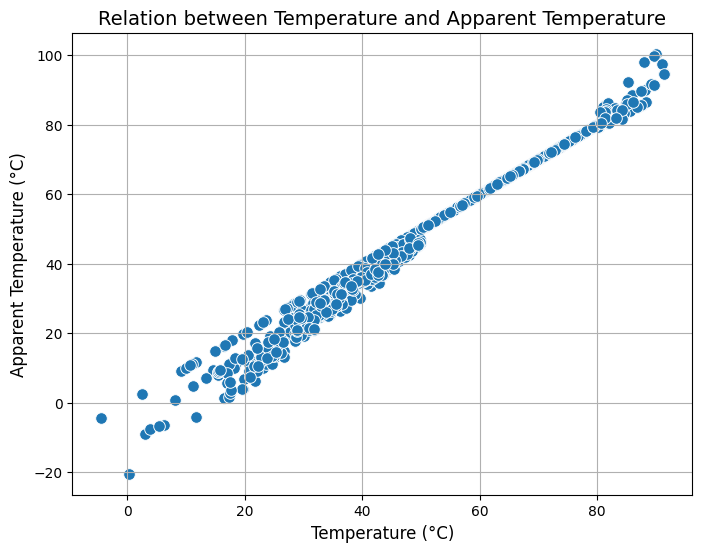

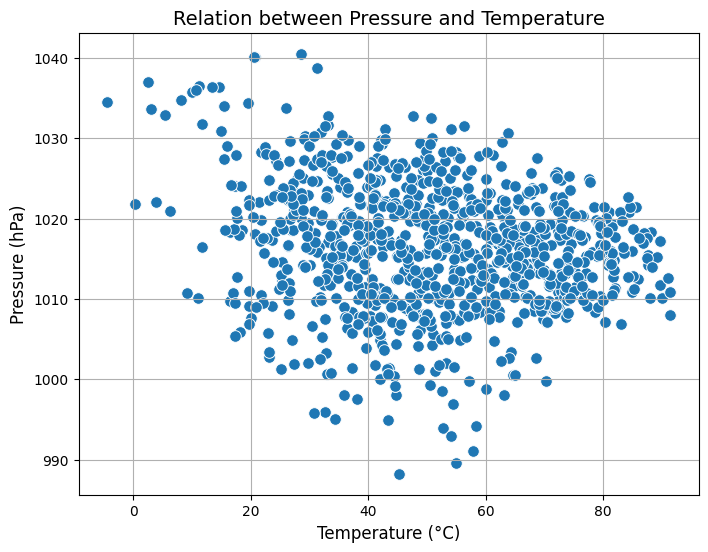

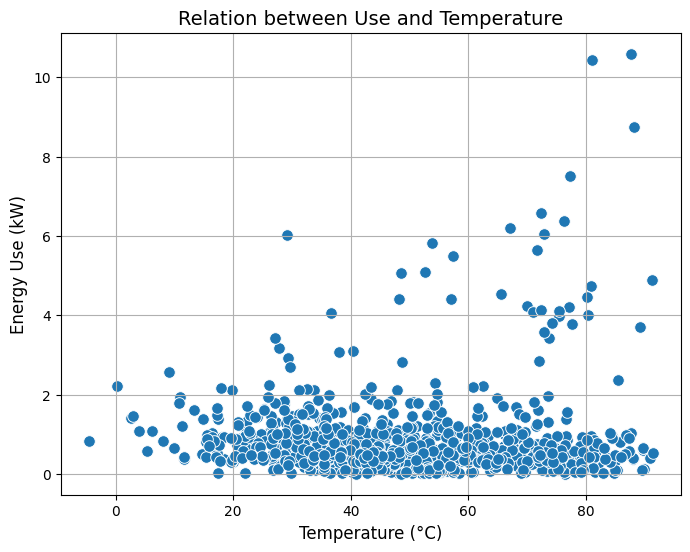

In [38]:
# First scatterplot - Relation between Temperature and Humidity
plt.figure(figsize=(8, 6))
plt.title('Relation between Temperature and Humidity', fontsize=14)
sns.scatterplot(data=data.sample(1000, random_state=1), x='temperature', y='humidity', s=70)
plt.xlabel('Temperature (°C)', fontsize=12)
plt.ylabel('Humidity (%)', fontsize=12)
plt.grid(True)
plt.show()

# Second scatterplot - Relation between Temperature and Apparent Temperature
plt.figure(figsize=(8, 6))
plt.title('Relation between Temperature and Apparent Temperature', fontsize=14)
sns.scatterplot(data=data.sample(1000, random_state=1), x='temperature', y='apparentTemperature', s=70)
plt.xlabel('Temperature (°C)', fontsize=12)
plt.ylabel('Apparent Temperature (°C)', fontsize=12)
plt.grid(True)
plt.show()

# Third scatterplot - Relation between Pressure and Temperature
plt.figure(figsize=(8, 6))
plt.title('Relation between Pressure and Temperature', fontsize=14)
sns.scatterplot(data=data.sample(1000, random_state=1), x='temperature', y='pressure', s=70)
plt.xlabel('Temperature (°C)', fontsize=12)
plt.ylabel('Pressure (hPa)', fontsize=12)
plt.grid(True)
plt.show()

# Fourth scatterplot - Relation between Use and Temperature
plt.figure(figsize=(8, 6))
plt.title('Relation between Use and Temperature', fontsize=14)
sns.scatterplot(data=data.sample(1000, random_state=1), x='temperature', y='use', s=70)
plt.xlabel('Temperature (°C)', fontsize=12)
plt.ylabel('Energy Use (kW)', fontsize=12)
plt.grid(True)
plt.show()

In [39]:
# Function to remove outliers based on IQR
def remove_outliers(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

In [40]:
# Remove outliers for both appliance and weather-related columns
data_no_outliers = remove_outliers(data, appliance_columns + weather_columns)

# Min-Max Standardization
scaler = MinMaxScaler()
data_standardized = scaler.fit_transform(data_no_outliers[appliance_columns + weather_columns])

# Convert standardized data back to DataFrame for easier plotting
data_standardized_df = pd.DataFrame(data_standardized, columns=appliance_columns + weather_columns)


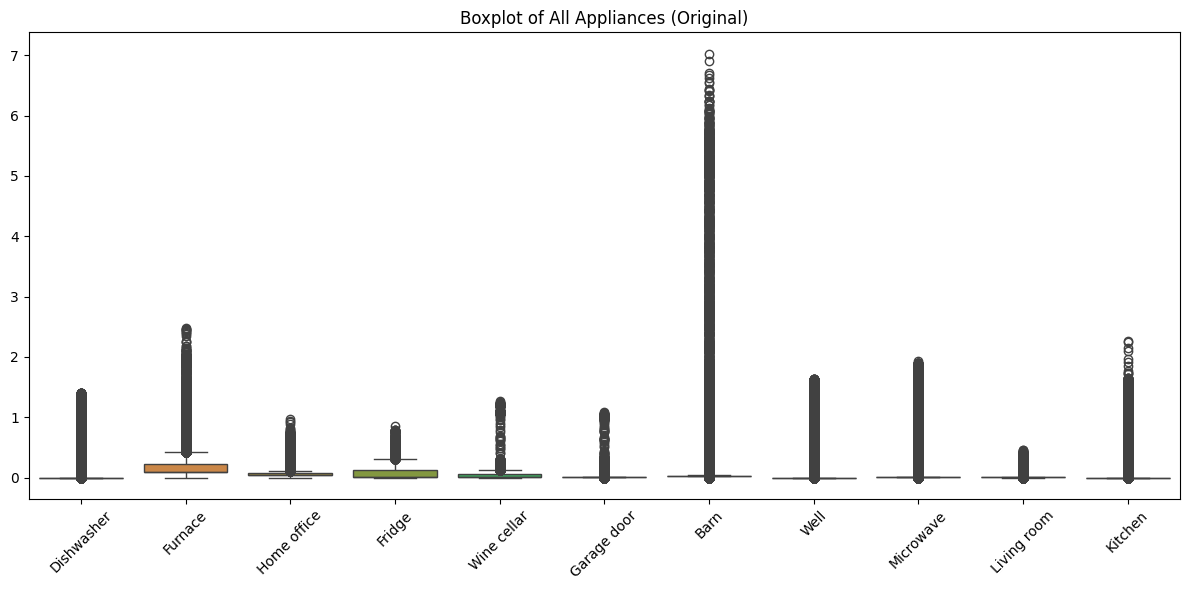

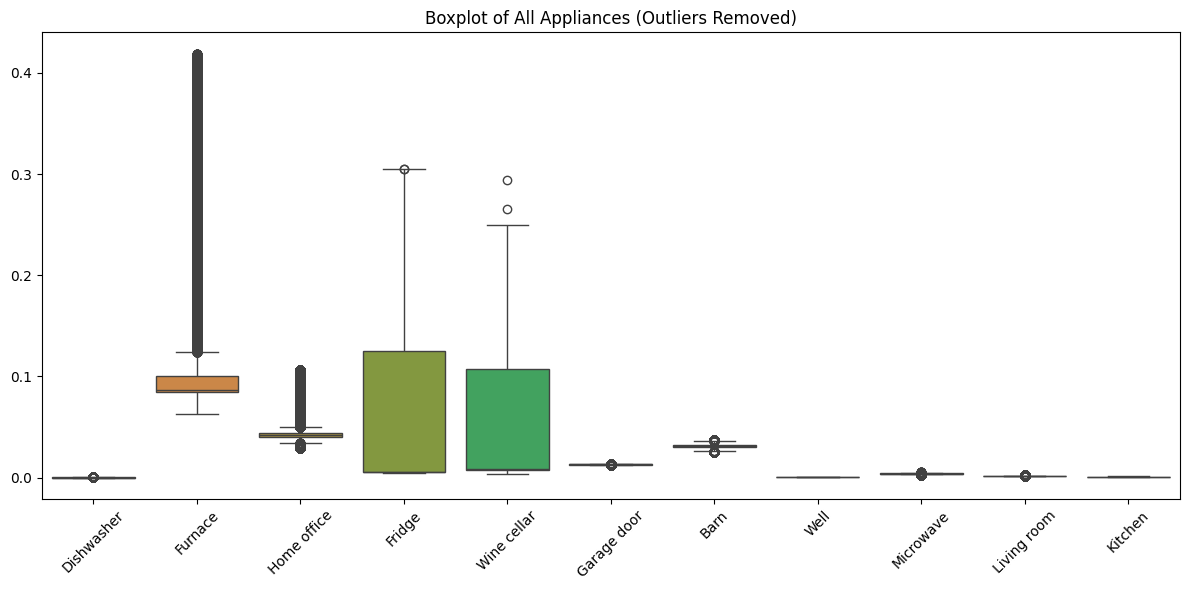

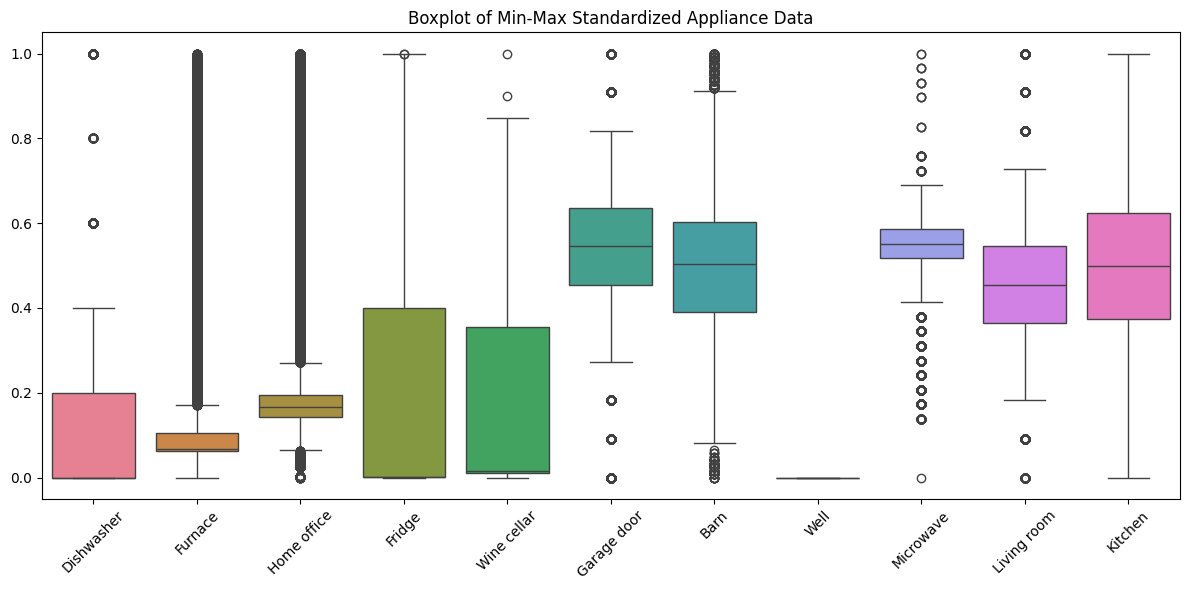

In [41]:
# 1. Boxplot for original appliance data
plt.figure(figsize=(12, 6))
sns.boxplot(data=data[appliance_columns])
plt.title('Boxplot of All Appliances (Original)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Boxplot for outliers removed
plt.figure(figsize=(12, 6))
sns.boxplot(data=data_no_outliers[appliance_columns])
plt.title('Boxplot of All Appliances (Outliers Removed)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 3. Boxplot for min-max standardized appliance data
plt.figure(figsize=(12, 6))
sns.boxplot(data=data_standardized_df[appliance_columns])
plt.title('Boxplot of Min-Max Standardized Appliance Data')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

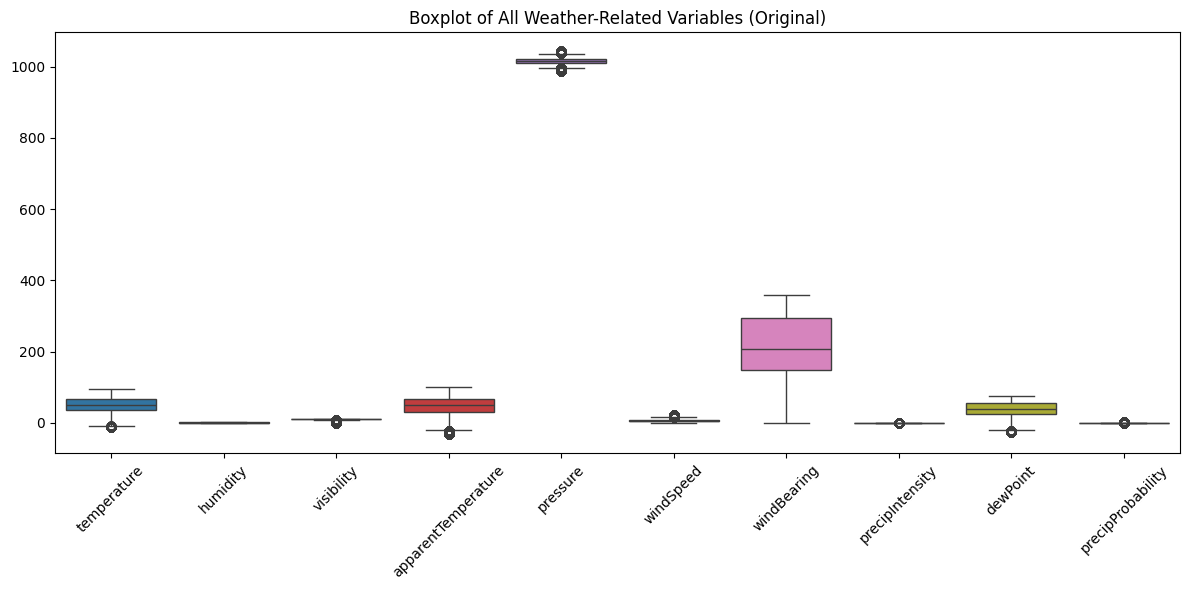

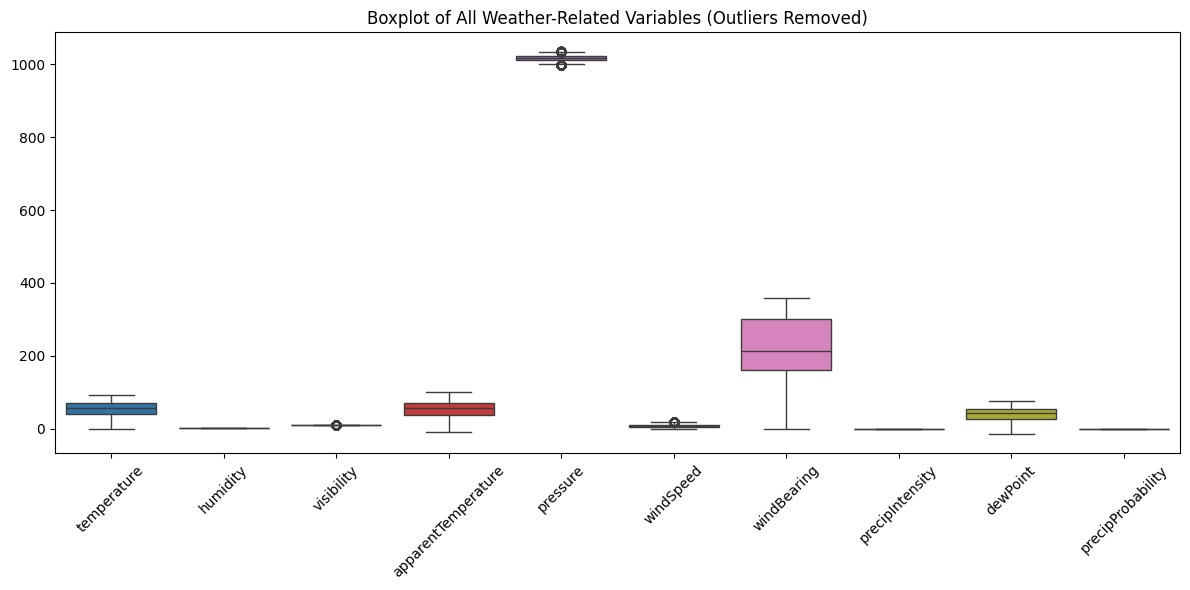

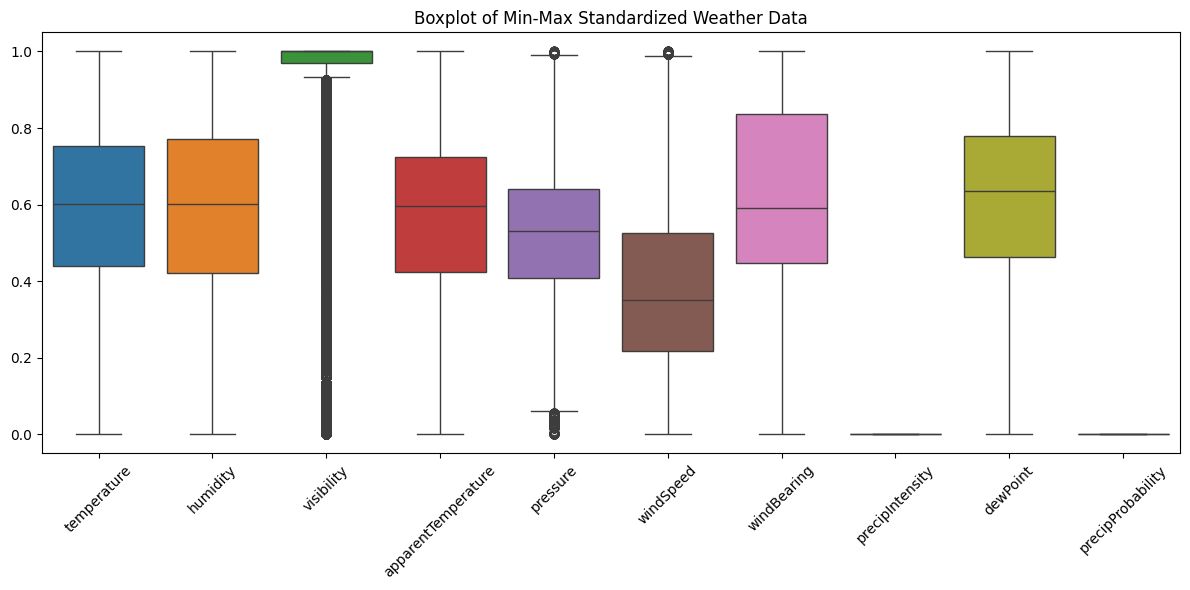

In [42]:
# 4. Boxplot for original weather data
plt.figure(figsize=(12, 6))
sns.boxplot(data=data[weather_columns])
plt.title('Boxplot of All Weather-Related Variables (Original)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5. Boxplot for outliers removed
plt.figure(figsize=(12, 6))
sns.boxplot(data=data_no_outliers[weather_columns])
plt.title('Boxplot of All Weather-Related Variables (Outliers Removed)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 6. Boxplot for min-max standardized weather data
plt.figure(figsize=(12, 6))
sns.boxplot(data=data_standardized_df[weather_columns])
plt.title('Boxplot of Min-Max Standardized Weather Data')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

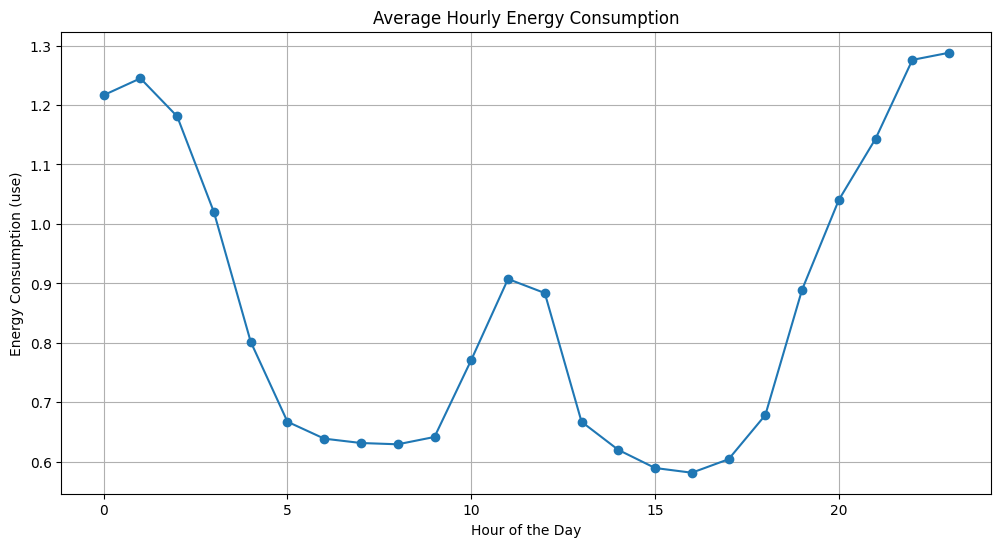

In [43]:
hourly_usage = data.groupby('hour')['use'].mean()

# Plot hourly energy consumption pattern
plt.figure(figsize=(12, 6))
plt.plot(hourly_usage.index, hourly_usage.values, marker='o')
plt.title('Average Hourly Energy Consumption')
plt.xlabel('Hour of the Day')
plt.ylabel('Energy Consumption (use)')
plt.grid(True)
plt.show()

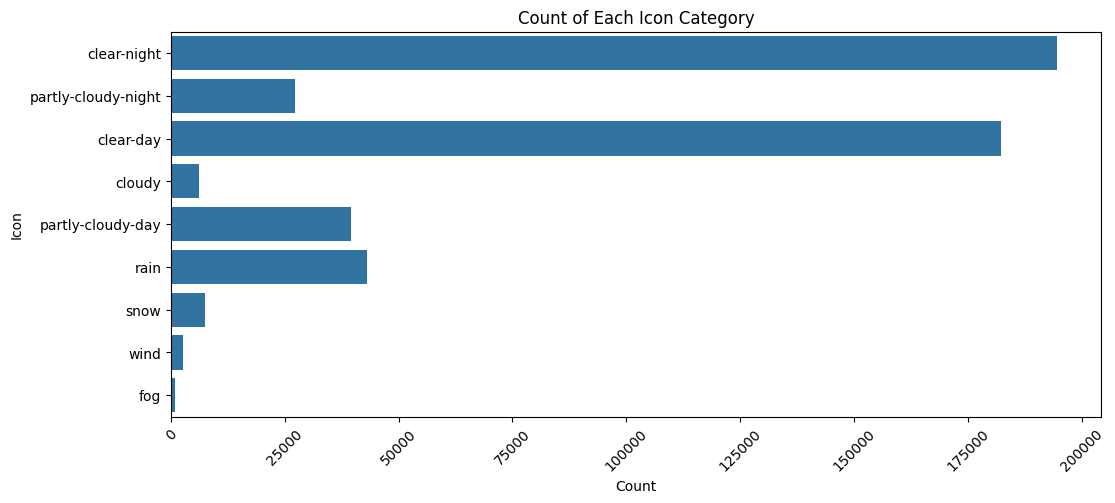

In [44]:
# plot Icon vs count
plt.figure(figsize=(12, 5))
sns.countplot(data['icon'])
plt.title('Count of Each Icon Category')
plt.xlabel('Count')
plt.ylabel('Icon')
plt.xticks(rotation=45)
plt.show()

In [45]:
# Perform label encoding on the icon column
label_encoder = LabelEncoder()
data['icon_encoded'] = label_encoder.fit_transform(data['icon'])
print("Label encoding completed successfully.")

Label encoding completed successfully.


In [46]:
# Create a dictionary mapping each icon to its encoded value
icon_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Display the mapping
print("Mapping of Encoded value and the Icon:")
for icon, encoded_value in icon_mapping.items():
    print(f"{encoded_value} : {icon}")

Mapping of Encoded value and the Icon:
0 : clear-day
1 : clear-night
2 : cloudy
3 : fog
4 : partly-cloudy-day
5 : partly-cloudy-night
6 : rain
7 : snow
8 : wind


In [47]:
# Drop the original 'icon' column
data = data.drop(columns=['icon'])

In [48]:
data.columns

Index(['use', 'gen', 'Dishwasher', 'Home office', 'Fridge', 'Wine cellar',
       'Garage door', 'Barn', 'Well', 'Microwave', 'Living room',
       'temperature', 'humidity', 'visibility', 'apparentTemperature',
       'pressure', 'windSpeed', 'windBearing', 'precipIntensity', 'dewPoint',
       'precipProbability', 'Furnace', 'Kitchen', 'datetime', 'date', 'hour',
       'minute', 'week', 'month', 'time_of_day', 'season', 'icon_encoded'],
      dtype='object')

In [49]:
# Standardize all the numeric columns in the dataset
scaler = MinMaxScaler()
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

# Drop the date and time related columns if they exist
date_time_columns = ['datetime', 'date', 'hour', 'minute', 'week', 'month', 'time_of_day', 'season']

data_filtered = data.drop(columns=[col for col in date_time_columns if col in data.columns])


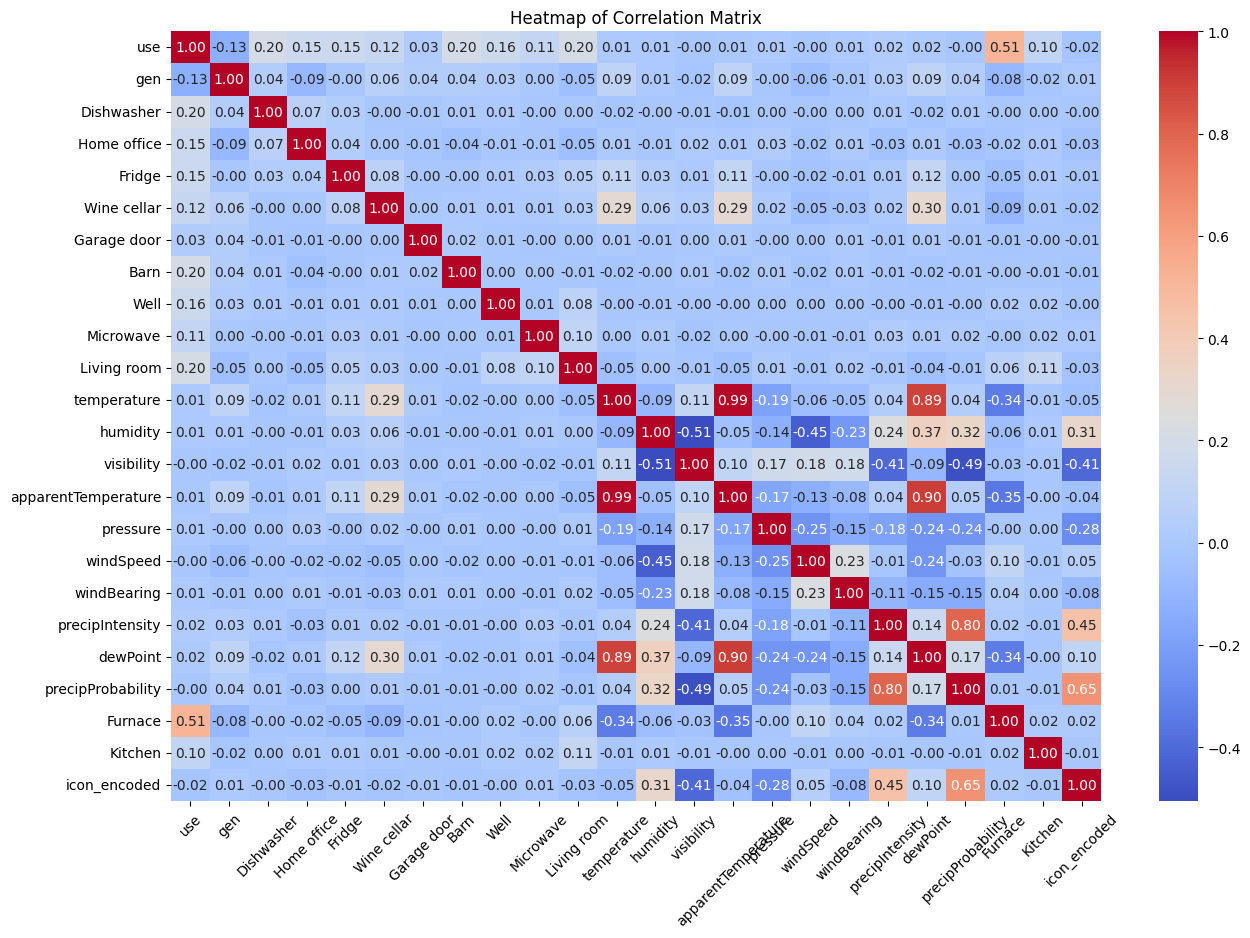

In [50]:
# Calculate the correlation matrix
corr_matrix = data_filtered.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap of Correlation Matrix')
plt.xticks(rotation=45)
plt.show()


In [51]:
# Define the columns to remove
columns_to_remove = ['apparentTemperature', 'dewPoint', 'precipProbability',
                     'datetime', 'date', 'hour', 'minute', 'week', 'month', 'time_of_day', 'season']

# Create a temporary DataFrame by removing the specified columns from the original data
temp_data = data.drop(columns=columns_to_remove)

# Select only numeric columns from the temporary DataFrame
temp_data_numeric = temp_data.select_dtypes(include=[np.number])

# Calculate the correlation matrix for the reduced dataset in the temporary DataFrame
correlation_matrix_reduced = temp_data_numeric.corr()

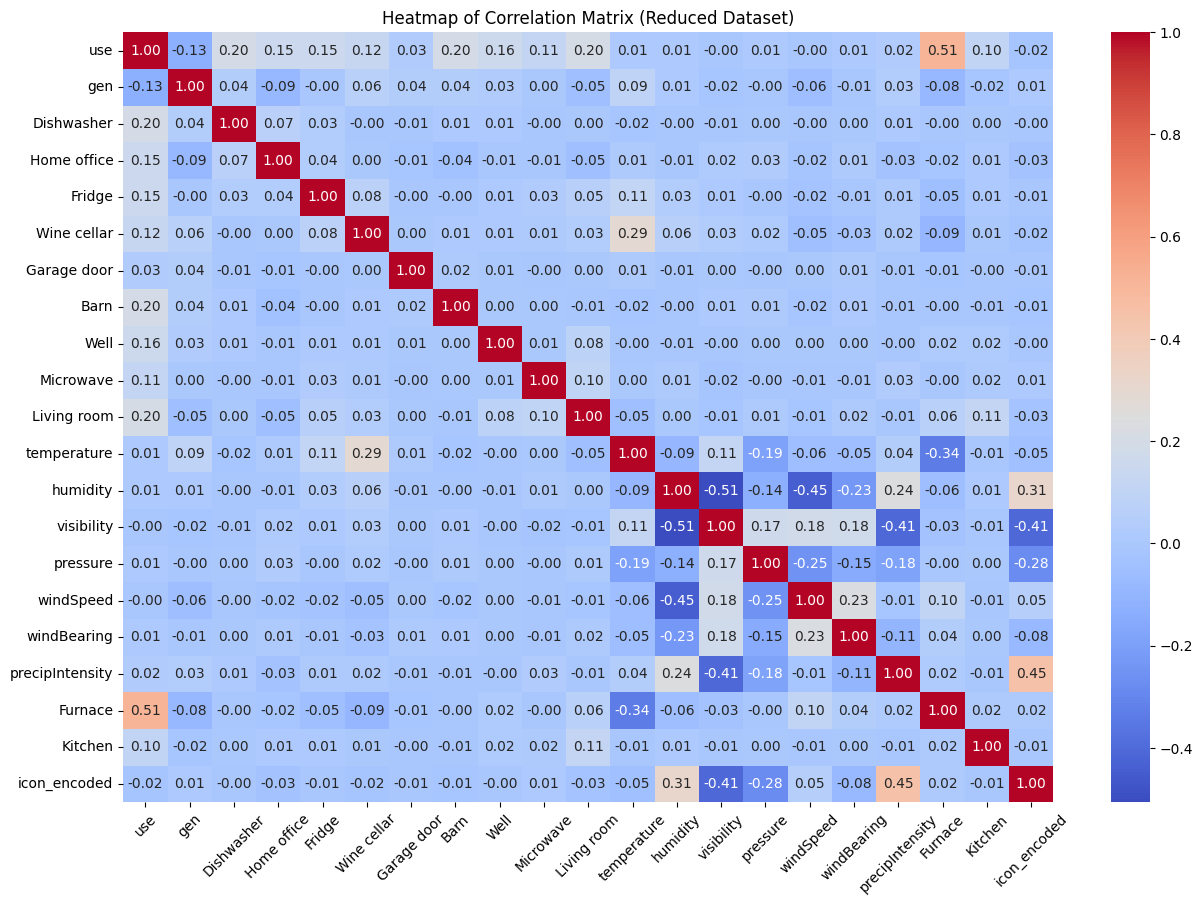

In [52]:
# Plot the correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix_reduced, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap of Correlation Matrix (Reduced Dataset)')
plt.xticks(rotation=45)
plt.show()

In [53]:
data.columns

Index(['use', 'gen', 'Dishwasher', 'Home office', 'Fridge', 'Wine cellar',
       'Garage door', 'Barn', 'Well', 'Microwave', 'Living room',
       'temperature', 'humidity', 'visibility', 'apparentTemperature',
       'pressure', 'windSpeed', 'windBearing', 'precipIntensity', 'dewPoint',
       'precipProbability', 'Furnace', 'Kitchen', 'datetime', 'date', 'hour',
       'minute', 'week', 'month', 'time_of_day', 'season', 'icon_encoded'],
      dtype='object')

In [54]:
# Save the final cleaned data to a new file
data.to_csv('/content/drive/MyDrive/Google colab/final_data.csv', index=False)

In [55]:
# Load the final cleaned dataset
final = pd.read_csv('/content/drive/MyDrive/Google colab/final_data.csv')

In [56]:
final.head()

,use,gen,Dishwasher,Home office,Fridge,Wine cellar,Garage door,Barn,Well,Microwave,Living room,temperature,humidity,visibility,apparentTemperature,pressure,windSpeed,windBearing,precipIntensity,dewPoint,precipProbability,Furnace,Kitchen,datetime,date,hour,minute,week,month,time_of_day,season,icon_encoded
0,0.063393,0.005701,0.000000,0.455387,0.145794,0.005495,0.012029,0.004468,0.000612,0.002125,0.003224,0.458631,0.576471,1.0,0.460511,0.544238,0.400698,0.785515,0.0,0.502677,0.0,0.033289,0.000265,2016-01-01,2016-01-01,0.217391,0.000000,53,0.0,Night,Winter,0.125
1,0.063495,0.005701,0.000000,0.456931,0.145559,0.005495,0.012029,0.004482,0.000612,0.002125,0.003439,0.458631,0.576471,1.0,0.460511,0.544238,0.400698,0.785515,0.0,0.502677,0.0,0.034057,0.000265,2016-01-01,2016-01-01,0.217391,0.016949,53,0.0,Night,Winter,0.125
2,0.063325,0.005701,0.000000,0.458989,0.144972,0.005495,0.012029,0.004482,0.000612,0.002125,0.003439,0.458631,0.576471,1.0,0.460511,0.544238,0.400698,0.785515,0.0,0.502677,0.0,0.033451,0.000265,2016-01-01,2016-01-01,0.217391,0.033898,53,0.0,Night,Winter,0.125
3,0.069455,0.005701,0.000000,0.459504,0.144502,0.005495,0.011938,0.004482,0.000612,0.002125,0.003439,0.458631,0.576471,1.0,0.460511,0.544238,0.400698,0.785515,0.0,0.502677,0.0,0.070825,0.000265,2016-01-01,2016-01-01,0.217391,0.050847,53,0.0,Night,Winter,0.125
4,0.077433,0.005701,0.000071,0.459401,0.144149,0.005338,0.011754,0.004482,0.000612,0.002125,0.003439,0.458631,0.576471,1.0,0.460511,0.544238,0.400698,0.785515,0.0,0.502677,0.0,0.121587,0.000353,2016-01-01,2016-01-01,0.217391,0.067797,53,0.0,Night,Winter,0.125


## Model Development and Analysis

In [57]:
# Drop non-numeric and target columns
df_clean = final.drop(columns=['use', 'datetime', 'date','time_of_day','season'])
target_column = 'use'

In [58]:
# Define features and target
X = df_clean
y = final[target_column]

# Split the data into training and testing sets as 70:30 respectively
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

##Linear Regression

In [59]:
# Initialize and train the Linear Regression model
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# Predict and evaluate
y_pred_lr = model_lr.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)

# Print evaluation metrics
print(f'Linear Regression - MSE: {mse_lr}')
print(f'Linear Regression - R²: {r2_lr}')
print(f'Linear Regression - RMSE: {rmse_lr}')

Linear Regression - MSE: 0.0024667078975319215
Linear Regression - R²: 0.5219803212050282
Linear Regression - RMSE: 0.04966596316927641


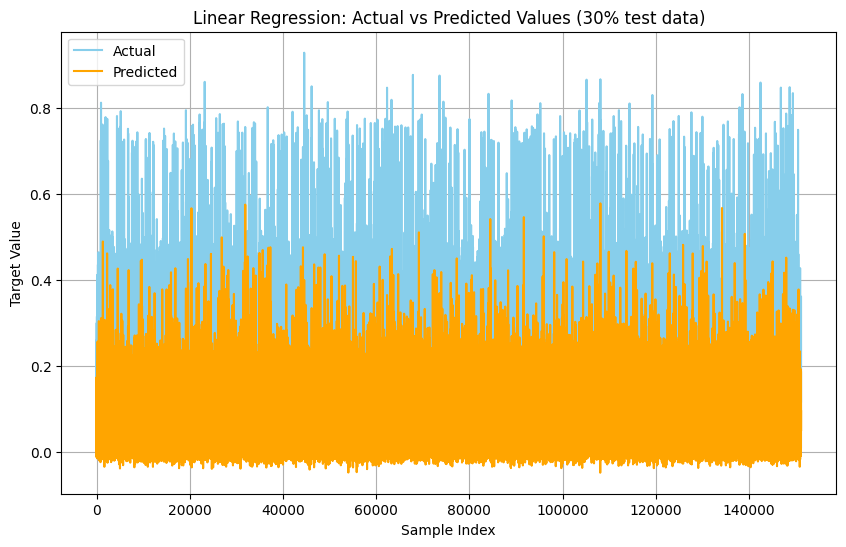

In [60]:
# Plot Actual vs Predicted for Linear Regression
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', color='skyblue')
plt.plot(y_pred_lr, label='Predicted', color='orange')
plt.title('Linear Regression: Actual vs Predicted Values (30% test data)')
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.legend()
plt.grid(True)
plt.show()

##Decision Tree Regressor

In [61]:
# Initialize and train the Decision Tree Regressor
model_dt = DecisionTreeRegressor(random_state=42)
model_dt.fit(X_train, y_train)

# Predict and evaluate
y_pred_dt = model_dt.predict(X_test)

mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)

# Print evaluation metrics
print(f'Decision Tree - MSE: {mse_dt}')
print(f'Decision Tree - R²: {r2_dt}')
print(f'Decision Tree - RMSE: {rmse_dt}')

Decision Tree - MSE: 0.0002993087069635057
Decision Tree - R²: 0.9419974079191183
Decision Tree - RMSE: 0.017300540655236927


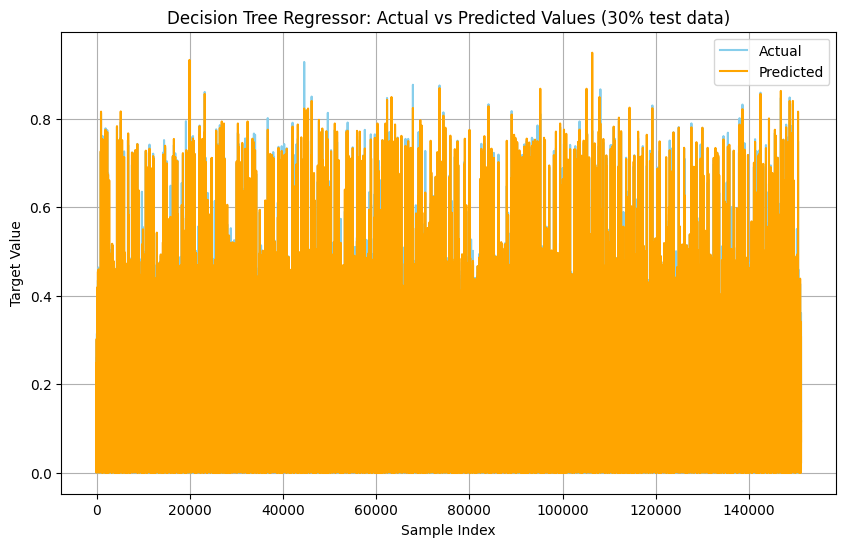

In [62]:
# Plot Actual vs Predicted for Decision Tree Regressor
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', color='skyblue')
plt.plot(y_pred_dt, label='Predicted', color='orange')
plt.title('Decision Tree Regressor: Actual vs Predicted Values (30% test data)')
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.legend()
plt.grid(True)
plt.show()

## Random Forest Regressor

In [63]:
# Initialize and train the Random Forest Regressor
model_rf = RandomForestRegressor(n_estimators=10, random_state=42)
model_rf.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = model_rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

# Print evaluation metrics
print(f'Random Forest - MSE: {mse_rf}')
print(f'Random Forest - R²: {r2_rf}')
print(f'Random Forest - RMSE: {rmse_rf}')

Random Forest - MSE: 0.00017228861901048546
Random Forest - R²: 0.9666124430858536
Random Forest - RMSE: 0.013125875933075303


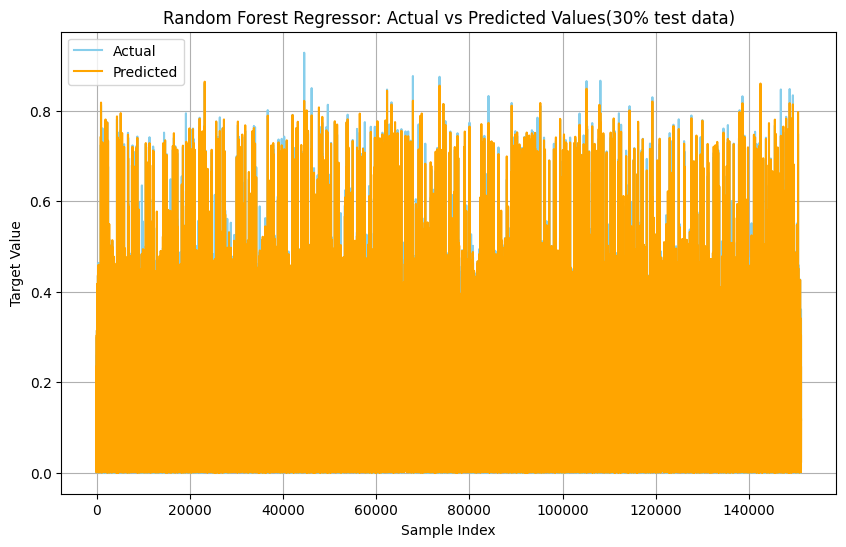

In [64]:
# Plot Actual vs Predicted for Random Forest Regressor
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', color='skyblue')
plt.plot(y_pred_rf, label='Predicted', color='orange')
plt.title('Random Forest Regressor: Actual vs Predicted Values(30% test data)')
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.legend()
plt.grid(True)
plt.show()


## Artificial Neural Network

In [65]:
# Build the first ANN model
model = Sequential()

# Input layer
model.add(Dense(units=64, activation='relu', input_shape=(X.shape[1],)))

# Hidden layers
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=32, activation='relu'))

# Output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Predict and evaluate
y_pred = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
11024/11024 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - loss: 0.0075
Epoch 2/10
11024/11024 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 0.0011
Epoch 3/10
11024/11024 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 8.7034e-04
Epoch 4/10
11024/11024 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 8.1811e-04
Epoch 5/10
11024/11024 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 7.5215e-04
Epoch 6/10
11024/11024 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 7.2519e-04
Epoch 7/10
11024/11024 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 7.2084e-04
Epoch 8/10
11024/11024 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - loss: 6.9330e-04
Epoch 9/10
11024/11024 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 6.7268e-04
Epoch 10/10
11024/11024 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 6.8108e-04
4725/4725 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step


In [66]:
# Calculate evaluation metrics
mse_1 = mean_squared_error(y_test, y_pred)
r2_1 = r2_score(y_test, y_pred)
rmse_1 = np.sqrt(mse_1)

# Print evaluation metrics
print(f"Model 1 - ANN MSE: {mse_1}")
print(f"Model 1 - ANN R2: {r2_1}")
print(f"Model 1 - ANN RMSE: {rmse_1}")

Model 1 - ANN MSE: 0.0006839227838903655
Model 1 - ANN R2: 0.8674636142354165
Model 1 - ANN RMSE: 0.026151917403708


In [67]:
# Build the second ANN model
model_2 = Sequential()

# Input layer
model_2.add(Dense(units=128, activation='relu', input_shape=(X_train.shape[1],)))

# Hidden layers
model_2.add(Dense(units=64, activation='relu'))
model_2.add(Dense(units=64, activation='relu'))
model_2.add(Dense(units=32, activation='relu'))

# Output layer
model_2.add(Dense(units=1))

# Compile the model with a different optimizer and loss function
model_2.compile(optimizer=Adam(learning_rate=0.001), loss=Huber())

# Train the model with more epochs
model_2.fit(X_train, y_train, epochs=30, batch_size=32)

# Predict and evaluate
y_pred_2 = model_2.predict(X_test)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
11024/11024 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 0.0018
Epoch 2/30
11024/11024 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - loss: 4.6842e-04
Epoch 3/30
11024/11024 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 4.0837e-04
Epoch 4/30
11024/11024 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 3.8790e-04
Epoch 5/30
11024/11024 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - loss: 3.6598e-04
Epoch 6/30
11024/11024 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 3.4387e-04
Epoch 7/30
11024/11024 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - loss: 3.4842e-04
Epoch 8/30
11024/11024 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - loss: 3.3695e-04
Epoch 9/30
11024/11024 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 3.4036e-04
Epoch 10/30
11024/11024 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - loss: 3.3979e-04
Epoch 11/30
11024/11024 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - loss: 3.2230e-04
Epoch 12/30
11024/11024 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - loss: 3.2139e-04
Epoch 13/30
11024/11024 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - loss: 3.2529e-04
Epoch 14/30


In [68]:
# Calculate evaluation metrics
mse_2 = mean_squared_error(y_test, y_pred_2)
r2_2 = r2_score(y_test, y_pred_2)
rmse_2 = np.sqrt(mse_2)

# Print evaluation metrics
print(f"Model 2 - ANN MSE: {mse_2}")
print(f"Model 2 - ANN R2: {r2_2}")
print(f"Model 2 - ANN RMSE: {rmse_2}")

Model 2 - ANN MSE: 0.0006948864972689911
Model 2 - ANN R2: 0.8653389724191339
Model 2 - ANN RMSE: 0.026360699863034576


In [69]:
# Build the third ANN model
model_3 = Sequential()

# Input layer
model_3.add(Dense(units=256, activation='relu', input_shape=(X.shape[1],)))

# Hidden layers
model_3.add(Dense(units=128, activation='relu'))
model_3.add(Dense(units=64, activation='relu'))
model_3.add(Dense(units=32, activation='relu'))

# Output layer
model_3.add(Dense(units=1))

# Compile the model
model_3.compile(optimizer=Adamax(), loss=Huber())

# Train the model
model_3.fit(X_train, y_train, epochs=50, batch_size=64)

# Predict and evaluate
y_pred_3 = model_3.predict(X_test)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
5512/5512 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - loss: 0.0040
Epoch 2/50
5512/5512 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - loss: 6.0373e-04
Epoch 3/50
5512/5512 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - loss: 4.6576e-04
Epoch 4/50
5512/5512 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - loss: 4.1989e-04
Epoch 5/50
5512/5512 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - loss: 4.0219e-04
Epoch 6/50
5512/5512 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 3.7872e-04
Epoch 7/50
5512/5512 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - loss: 3.8959e-04
Epoch 8/50
5512/5512 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 3.7136e-04
Epoch 9/50
5512/5512 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - loss: 3.4865e-04
Epoch 10/50
5512/5512 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - loss: 3.5972e-04
Epoch 11/50
5512/5512 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - loss: 3.4346e-04
Epoch 12/50
5512/5512 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - loss: 3.3044e-04
Epoch 13/50
5512/5512 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - loss: 3.2925e-04
Epoch 14/50
5512/5512 ━━━━━━━━━━━━━━━━

In [70]:
# Calculate evaluation metrics
mse_3 = mean_squared_error(y_test, y_pred_3)
r2_3 = r2_score(y_test, y_pred_3)
rmse_3 = np.sqrt(mse_3)

# Print evaluation metrics
print(f"Model 3 - ANN MSE: {mse_3}")
print(f"Model 3 - ANN R2: {r2_3}")
print(f"Model 3 - ANN RMSE: {rmse_3}")

Model 3 - ANN MSE: 0.00046787251752300035
Model 3 - ANN R2: 0.9093316761311236
Model 3 - ANN RMSE: 0.021630361012313234


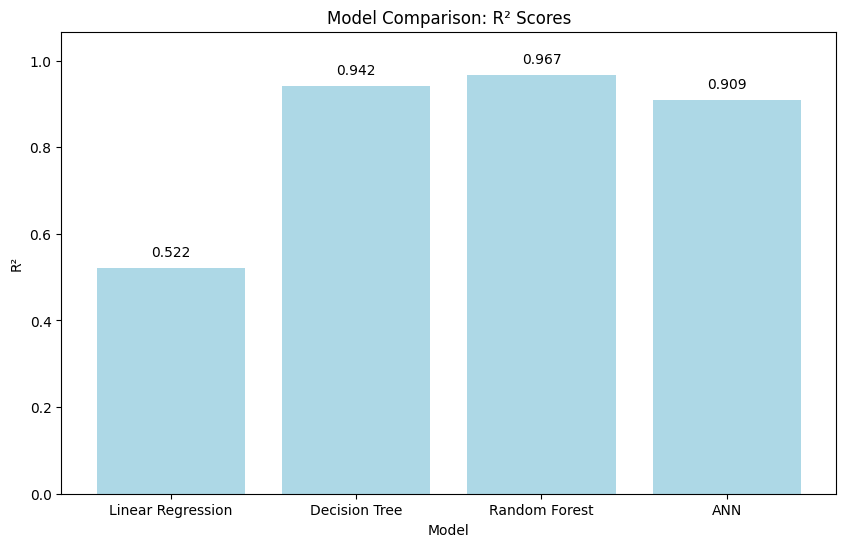

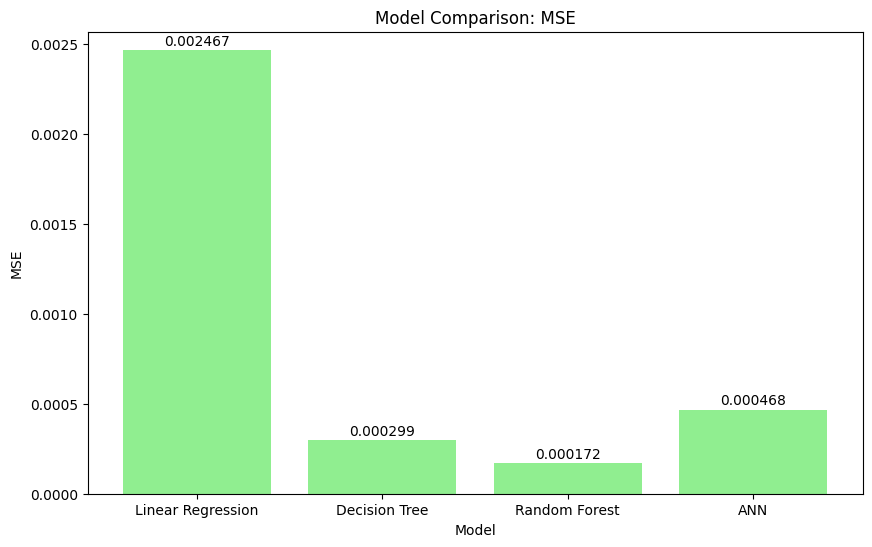

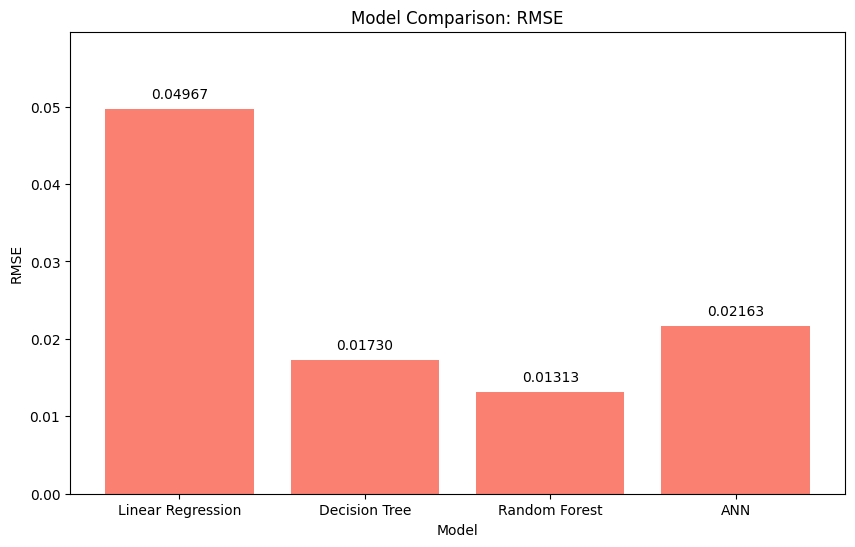

In [71]:
# Define models and their corresponding metrics
models = ['Linear Regression', 'Decision Tree', 'Random Forest', 'ANN']
r2_scores = [r2_lr, r2_dt, r2_rf, r2_3]
mses = [mse_lr, mse_dt, mse_rf, mse_3]
rmses = [rmse_lr, rmse_dt, rmse_rf, rmse_3]

# Set y-axis limit to allow for values to be displayed above bars
y_max_r2 = max(r2_scores) + 0.1
y_max_mse = max(mses) + 0.0001
y_max_rmse = max(rmses) + 0.01

# Plot R square scores
plt.figure(figsize=(10, 6))
plt.bar(models, r2_scores, color='lightblue')
for i, v in enumerate(r2_scores):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center', va='bottom')
plt.ylim(0, y_max_r2)
plt.title('Model Comparison: R² Scores')
plt.xlabel('Model')
plt.ylabel('R²')
plt.show()

# Plot MSE
plt.figure(figsize=(10, 6))
plt.bar(models, mses, color='lightgreen')
for i, v in enumerate(mses):
    plt.text(i, v + 0.00001, f"{v:.6f}", ha='center', va='bottom')
plt.ylim(0, y_max_mse)
plt.title('Model Comparison: MSE')
plt.xlabel('Model')
plt.ylabel('MSE')
plt.show()

# Plot RMSE
plt.figure(figsize=(10, 6))
plt.bar(models, rmses, color='salmon')
for i, v in enumerate(rmses):
    plt.text(i, v + 0.001, f"{v:.5f}", ha='center', va='bottom')
plt.ylim(0, y_max_rmse)
plt.title('Model Comparison: RMSE')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.show()


##ARIMA model

In [72]:
# Assuming the correct column is 'date'
final['date'] = pd.to_datetime(final['date'])
final.set_index('date', inplace=True)


# Resample the data to a monthly frequency and sum the energy usage
monthly_df = final['use'].resample('M').sum()

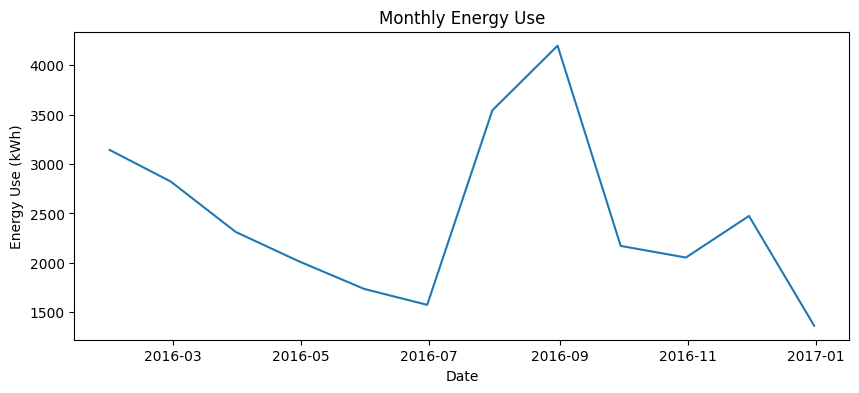

In [73]:
# Plot the data to visualize
plt.figure(figsize=(10, 4))
plt.plot(monthly_df)
plt.title('Monthly Energy Use')
plt.xlabel('Date')
plt.ylabel('Energy Use (kWh)')
plt.show()

In [74]:
# Fit the ARIMA model
model = ARIMA(monthly_df, order=(5, 1, 0))
model_fit = model.fit()

# Print summary of the model
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                    use   No. Observations:                   12
Model:                 ARIMA(5, 1, 0)   Log Likelihood                 -85.060
Date:                Fri, 30 Aug 2024   AIC                            182.119
Time:                        02:49:24   BIC                            184.507
Sample:                    01-31-2016   HQIC                           180.615
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3070      0.311     -0.987      0.324      -0.916       0.302
ar.L2         -0.9080      0.223     -4.075      0.000      -1.345      -0.471
ar.L3         -0.3979      0.520     -0.765      0.4

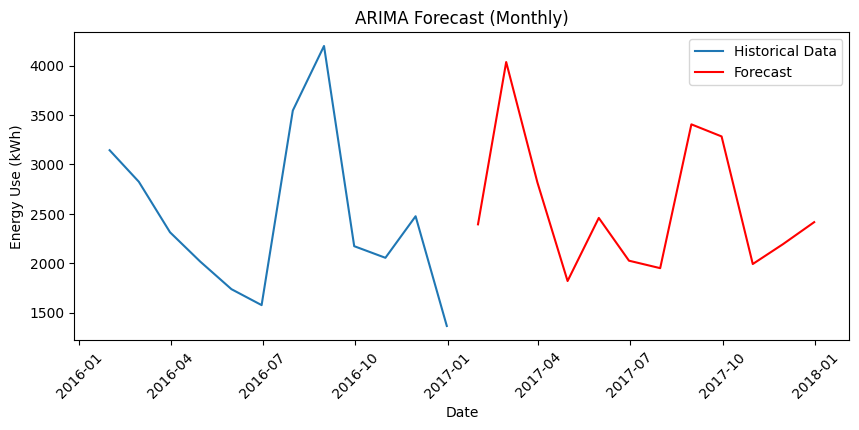

In [75]:
# Forecast for the next 12 months
forecast = model_fit.forecast(steps=12)
forecast_index = pd.date_range(start=monthly_df.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')
forecast_series = pd.Series(forecast, index=forecast_index)

# Plot the forecast
plt.figure(figsize=(10, 4))
plt.plot(monthly_df, label='Historical Data')
plt.plot(forecast_series, label='Forecast', color='red')
plt.title('ARIMA Forecast (Monthly)')
plt.xlabel('Date')
plt.ylabel('Energy Use (kWh)')
plt.legend()
plt.xticks(rotation=45)
plt.show()